# Gossip Girl

# Motivation 

Our motivation for doing this project is to explore the copmlex charachters in the well known tv show that we have grown up with: Gossip Girl by using a set of tools and techniques we have learned in the the Social Graphs course. 

Gossip Girl is a TV-series following complex and intervining charachters lifes. Troughout the series the charachters has countless realationships, enemies,freinds and family memebers. It is impossible for the viuer to keep track. We want to unpack and analyze the charachters relationships trouhgout the series

### 1.1 Data set 
Our data set consists of data from https://gossipgirl.fandom.com/wiki/Gossip_Girl_Wiki witch is a wiki. 

The wiki pages that has been scraped and used:
- /Category:Characters
- /{Name of the Charachter}
- /Category:Females
- /Category:Males
- /Category:Van_der_Woodsen_family
- /Category:Humphrey_family
- /Category:Bass_Family

Our Dataframe that holds most of the data consists of: 
 - Charachter: The name of the charachter 
 - Family: A list of family members 
 - Romances: A list of romances
 - Friends: A list of friends 
 - Enemies: A list of enemies
 - Size/Relationship: Total number ofrelationships
 - gender/color: a color based on if the charachter is female, male or other. 
 - Description: The description of the charachter. Only the top 10 most conected charachters has this attribute.

### 1.2 Why did we choose this dataset? 
We have grown up watching this show, and always struggeled keeping track on the families, the complex realationships and the charachters change of personality. We wanted to get a unique insight, and taught it would be fun to analyze this TV-show. The TW-show we have choosen has mainly female or femeine viewers. Our line of work and study is quite male dominated. We are two girls that want to bring more femeninity to programming, and therefor found it fitting choosing this TV-series as our dataset.

### 1.3 What was our goal for the dataset? 

We want to provide the user with a better understanding of the charachters in Gossip Girl and there relationships, and therefor enjoy the series evenmore with full a full overviw of the complex network by providing the users with:  
 - An elaborate Network analysis of the charachters and how they intertween.  
 - Network analysis of the charachters relationships, gender and number of relationships
 - Network analysis of the families and charachter 
 - Wordclouds of the most common words used to describe each charachter. 
 - Sentiment analasys of the description of the top 10 most conected charachters  

    

#### Imports used trought the notebook

In [1]:
#Import data fetching and cleaning 
import requests, re
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import lxml
import itertools
import copy

#Import data Network
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from fa2 import ForceAtlas2
import warnings

# Imports text analyze 
import re
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import math

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pylab
import random
from nltk.corpus import stopwords
from PIL import Image

# Imports senntiment
from nltk.sentiment import SentimentIntensityAnalyzer

from bs4 import Comment
from urllib.request import urlopen
 

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/olinezachariassen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/olinezachariassen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/olinezachariassen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Data and basic stats

Data cleaning and preprocessing has ben used to fetch: 
 - List of charachters 
 - The chrachters relatioships 
 - The gender of the charachters 
 - The Description of the charachter 
 
The data has been fetched to be used for Network analasys and text analasys. 

#### Data Cleaning and preprosseding 

To prosses and clean data the very popular Pytonlibrary Beautiful Soup has been used. Al data has been fetched by using the html tag and a unique identifier. The soup has then been cleaned by removing dublicates and data that we don't want to use like in the list of charachter one charachter is: 'Breakfast'.  For the description the text has been cleaned by using regular expression operations. The text was cleaned to be a list of words for worcloud and a list of setences for sentiment analasys. 

Our data is not very large, and we encountered some issues while prossesig the data. We had to add a main charachter. The page for eachcharachter contains a set of paragraphs that are enncapsulated in the same main with noidentifier. This constricted us a bit. 



### List of charachters/ nodes

Returns a list of charachters. 
Number of nodes before cleaning: 113

In [2]:
#Get list 

warnings.filterwarnings('ignore')


def CharacterList(url):
    websiteURL =  requests.get(url)
    soup = BeautifulSoup(websiteURL.text)
    characterGallery = soup.find_all('div',{'class':'category-page__members'})
    characters = []

    for character in characterGallery:

        images = character.findAll("img")
        for image in images:
            try:
                characterName = image.get("alt")
            except:
                pass

            characters.append(characterName)
            characters.append('Blair Waldorf')
            

    return characters


ListOfCharacter = CharacterList("https://gossipgirl.fandom.com/wiki/Category:Characters")
#ListOfCharacter

ListCharachters   = set(ListOfCharacter)

print("number of nodes: ", len(ListCharachters))




number of nodes:  113


#### Cleaning: List of charachters 
Removing duplicates and unwanted nodes that are not charachters 

In [3]:
toRemove = ["relationship", 'Gossip', 'Season', 'Tripp\xa0Vanderbilt','Social Media', 'Breakfast', 'Melanie91' ]

toRemove = set(toRemove)
listCharachters = [c for c in ListCharachters if not any(r in toRemove for r in c.split())]

print("number of nodes after stripping: ", len(listCharachters))


number of nodes after stripping:  97


### Create DF 
Crate DF to hold the data 

In [4]:

DF = pd.DataFrame(columns=['Character', 'Family', 'Romances', 'Friends', 'Enemies','size/Relastionship', 'gender/color', 'description'])
DF['Character'] = listCharachters





### Get relationships of charachter

Fetch and orginaize relationships, and storing the data in the dataframe.

In [5]:

def getRelationship(nodes):
    
    for i, charachter in enumerate(nodes):
        url =  requests.get(f"https://gossipgirl.fandom.com/wiki/{charachter}")
        soup = BeautifulSoup(url.text)

        Family= []
        Romances = []
        Friends = []
        Enemies = []

        try:
            infoBox = soup.findAll('section',{'class':'pi-item pi-group pi-border-color'})[1]
            family =  infoBox.findAll('div', {'data-source':"Family (only TV series)"}) 

            FamilyNames = re.findall('title="(.*?)"',str(family))

            FamilyNames = set(FamilyNames)
            for name in FamilyNames:
                if name in ListCharachters:
                    Family.append(name) 
        except: 
            Family= []
        try: 
            infoBox = soup.findAll('section',{'class':'pi-item pi-group pi-border-color'})[1]
            romances = infoBox.findAll('div', {'data-source':"Romances (only TV series)"})

            romanceNames = re.findall('title="(.*?)"',str(romances))
            romanceNames = set(romanceNames)
            for name in romanceNames:
                if name in ListCharachters:
                    Romances.append(name) 

        except:
            Romances = []
        try: 
            infoBox = soup.findAll('section',{'class':'pi-item pi-group pi-border-color'})[1]
            friends = infoBox.findAll('div', {'data-source':"Friends (only TV series)"})

            friendsNames = re.findall('title="(.*?)"',str(friends))
            friendsNames = set(friendsNames)
            for name in friendsNames:
                if name in ListCharachters:
                    Friends.append(name) 

        except:
            Friends = []

        try: 
            infoBox = soup.findAll('section',{'class':'pi-item pi-group pi-border-color'})[1]
            enemies = infoBox.findAll('div', {'data-source':"Enemies (only TV series)"})

            enemiesNames = re.findall('title="(.*?)"',str(enemies))
            enemiesNames = set(enemiesNames)
            for name in enemiesNames:
                if name in ListCharachters:
                    Enemies.append(name) 
        except:
            Enemies = []

        DF['Family'][i] = Family
        DF['Romances'][i] = Romances
        DF['Friends'][i] = Friends
        DF['Enemies'][i] = Enemies
        DF['size/Relastionship'][i] = len(Family) + len(Romances) + len(Friends) + len(Enemies)



### Clean text: Description of charachter 

Cleans and fetches the description of a charachter 

In [6]:
def getCleanText(charachter):
    
    try: 

        #for i, charachter in enumerate(charachters10):
        url =  requests.get(f"https://gossipgirl.fandom.com/wiki/{charachter}#Television_Series")
        soup = BeautifulSoup(url.text)

        infoBox = soup.findAll('div',{'class':'main-container'})
        infoBox = soup.findAll('div',{'class':'resizable-container'})
        infoBox = soup.findAll('div',{'class':'page has-right-rail'})
        infoBox = soup.findAll('div',{'class':'page-content'})
        infoBox = soup.findAll('p')[3:]



        letters_only = re.sub("[^a-zA-Z]"," ",str(infoBox))
        text = re.sub(r'\<.*?\>', '', letters_only)
        text = re.sub(r'\{\{.*?\}\}', '', text)
        text = re.sub(r'\[\[.*?\]\]', '', text)
        text = text.lower()
        text_tokens = word_tokenize(text)
        tokens = [word.lower() for word in text_tokens]
        tokens = [word for word in text_tokens if not word in stopwords.words()]
        removeList = ['p', 'a', 's','title','href','wiki']
        tokens = [word for word in text_tokens if not word in removeList]
        
        return tokens
    
    except:
        
        return []

### Gets gender of characheter

Uses the category pages that contains a table of males or females to decide the gender og the charachter and stores it in the dataframe. This will later decide the color of the nodes in the network.

In [7]:
def getGenders():
    websiteURL =  requests.get("https://gossipgirl.fandom.com/wiki/Category:Females")
    wesiteURL2 = requests.get("https://gossipgirl.fandom.com/wiki/Category:Males")
    soup = BeautifulSoup(websiteURL.text)
    soup2 = BeautifulSoup(wesiteURL2.text)
    FemaleGallery = soup.find_all('div',{'class':'category-page__members'})
    MaleGallery = soup2.find_all('div',{'class':'category-page__members'})
    females = []
    males = []
    for female in FemaleGallery:

        images = female.findAll("img")
        for image in images:
            try:
                characterName = image.get("alt")
            except:
                pass

            females.append(characterName)
            
    for male in MaleGallery:

        images = male.findAll("img")
        for image in images:
            try:
                characterName = image.get("alt")
            except:
                pass

            males.append(characterName)

    for i  in range(len(listCharachters)):
        if listCharachters[i] in females:
            DF['gender/color'][i] = 'pink'
        elif listCharachters[i] in males:
            DF['gender/color'][i] = '#add8e6'
        else: 
            DF['gender/color'][i] = 'grey'
            

getGenders()
getRelationship(listCharachters)



Character                                             Family  \
0         Eliot Garfield                                                 []   
1          Philip Becker                                  [Georgina Sparks]   
2         Anne Archibald  [Nate Archibald, Howard Archibald, William van...   
3   William van der Bilt  [Anne Archibald, Nate Archibald, Howard Archib...   
4             Aaron Rose       [Blair Waldorf, Cyrus Rose, Eleanor Waldorf]   
..                   ...                                                ...   
92  Headmistress Queller                                                 []   
93         Steven Spence                                      [Sage Spence]   
94                 Vanya                                [Dorota Kishlovsky]   
95      Jordan Glassberg                                                 []   
96       Gabriel Edwards                                                 []   

                                          Romances  \
0                           [Eric van der Woodsen]   
1                                [Georgina Sparks]   
2                               [Howard Archibald]   
3                                               []   
4                         [Serena van der Woodsen]   
..                                             ...   
92                                              []   
93  [Serena van der Woodsen, Lily van der Woodsen]   
94                             [Dorota Kishlovsky]   
95                                   [Kate Keller]   
96          [Serena van der Woodsen, Poppy Lifton]   

                                              Friends  \
0                                 [Dorota Kishlovsky]   
1                                                  []   
2             [Lily van der Woodsen, Eleanor Waldorf]   
3                                     [Blair Waldorf]   
4   [Serena van der Woodsen, Agnes Andrews, Dan Hu...   
..                                                ...   
92                                                 []   
93                           [Serena van der Woodsen]   
94      [Rufus Humphrey, Cyrus Rose, Eleanor Waldorf]   
95                       [Rafa Caparros, Kate Keller]   
96                                     [Poppy Lifton]   

                             Enemies size/Relastionship gender/color  \
0                                 []                  2      #add8e6   
1                                 []                  2      #add8e6   
2                                 []                  7         pink   
3                      [Diana Payne]                  6         grey   
4                                 []                  7      #add8e6   
..                               ...                ...          ...   
92                                []                  0         pink   
93                                []                  4      #add8e6   
94                                []                  5      #add8e6   
95  [Julien Calloway, Monet de Haan]                  5      #add8e6   
96            [Lily van der Woodsen]                  4      #add8e6   

   description  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  
..         ...  
92         NaN  
93         NaN  
94         NaN  
95         NaN  
96         NaN  

[97 rows x 8 columns]

### Dataframe

The data that has been fecthed an stored. See the explenation under the data and basic stats

In [56]:
DF

Character                                             Family  \
0         Eliot Garfield                                                 []   
1          Philip Becker                                  [Georgina Sparks]   
2         Anne Archibald  [Nate Archibald, Howard Archibald, William van...   
3   William van der Bilt  [Anne Archibald, Nate Archibald, Howard Archib...   
4             Aaron Rose       [Blair Waldorf, Cyrus Rose, Eleanor Waldorf]   
..                   ...                                                ...   
92  Headmistress Queller                                                 []   
93         Steven Spence                                      [Sage Spence]   
94                 Vanya                                [Dorota Kishlovsky]   
95      Jordan Glassberg                                                 []   
96       Gabriel Edwards                                                 []   

                                          Romances  \
0                           [Eric van der Woodsen]   
1                                [Georgina Sparks]   
2                               [Howard Archibald]   
3                                               []   
4                         [Serena van der Woodsen]   
..                                             ...   
92                                              []   
93  [Serena van der Woodsen, Lily van der Woodsen]   
94                             [Dorota Kishlovsky]   
95                                   [Kate Keller]   
96          [Serena van der Woodsen, Poppy Lifton]   

                                              Friends  \
0                                 [Dorota Kishlovsky]   
1                                                  []   
2             [Lily van der Woodsen, Eleanor Waldorf]   
3                                     [Blair Waldorf]   
4   [Serena van der Woodsen, Agnes Andrews, Dan Hu...   
..                                                ...   
92                                                 []   
93                           [Serena van der Woodsen]   
94      [Rufus Humphrey, Cyrus Rose, Eleanor Waldorf]   
95                       [Rafa Caparros, Kate Keller]   
96                                     [Poppy Lifton]   

                             Enemies size/Relastionship gender/color  \
0                                 []                  2      #add8e6   
1                                 []                  2      #add8e6   
2                                 []                  7         pink   
3                      [Diana Payne]                  6         grey   
4                                 []                  7      #add8e6   
..                               ...                ...          ...   
92                                []                  0         pink   
93                                []                  4      #add8e6   
94                                []                  5      #add8e6   
95  [Julien Calloway, Monet de Haan]                  5      #add8e6   
96            [Lily van der Woodsen]                  4      #add8e6   

   description  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  
..         ...  
92         NaN  
93         NaN  
94         NaN  
95         NaN  
96         NaN  

[97 rows x 8 columns]

# 3 Tools, theory and analysis. Describe the process of theory to insight

As discussed over we want to analyze the complex social lifes of the charachters in the TV-series. To do this we wat to find out who. is conected, how they are conected. Who has the most relationships with others. We also take a look into the compeeting families to see whohas the most influence in the social Network. We will also take a look into how the charachters is described to determend if their influence may be bad or good, or just complex? 



## 3.1 Creating the network and initial analysis

#### Network 
Multiple Networks has been created to analyze the social network in the TV-series. 

- Nodes: Charachter
- Edges: Relationship
- EdgeColors are determined by what kind ofrelationship
    - Family: grey 
    - Romances: pink 
    - Friends: blue
    - Enemies: purple
- Node size: Number of relationships. 

The networks created are:
  - The total Network with all charachters and all relationship
  - A function to create a network of a list of choosen nodes
      - Network for each of the top 10 most conected charachters 
      - Network for each family 

To create the networks we have used NetworkX that is a Python language software package that is good to use when analysing large and coplex network with nodes and edges. To plot the network we have used matplotlib.pyplot witch is a collection of functions that make matplotlib work like MATLAB so we can get easy readable graphs and networks.  


### help functions

In [11]:
## help function 

#get edge colors
def getEdgeColors(edges, edgeListFamily, edgeListRomances, edgeListFriends):
    colors = []
    for e in edges:
        if e in edgeListFamily:
            colors.append("grey")
        elif e in edgeListRomances:
            colors.append("pink")
        elif e in edgeListFriends:
            colors.append("blue")
        else: 
            colors.append("purple")
    return colors

def getGender(node):
    return DF['gender/color'][listCharachters.index(node)]

def getSize(node):
    return DF['size/Relastionship'][listCharachters.index(node)]

### Creates the whole network

We crate the whole social network to get an overview of the social Network. We can see witch charachters are most conected and who they are conected. We can see that it is a very conected graph, and charachters has many realationshipsto eachother. 

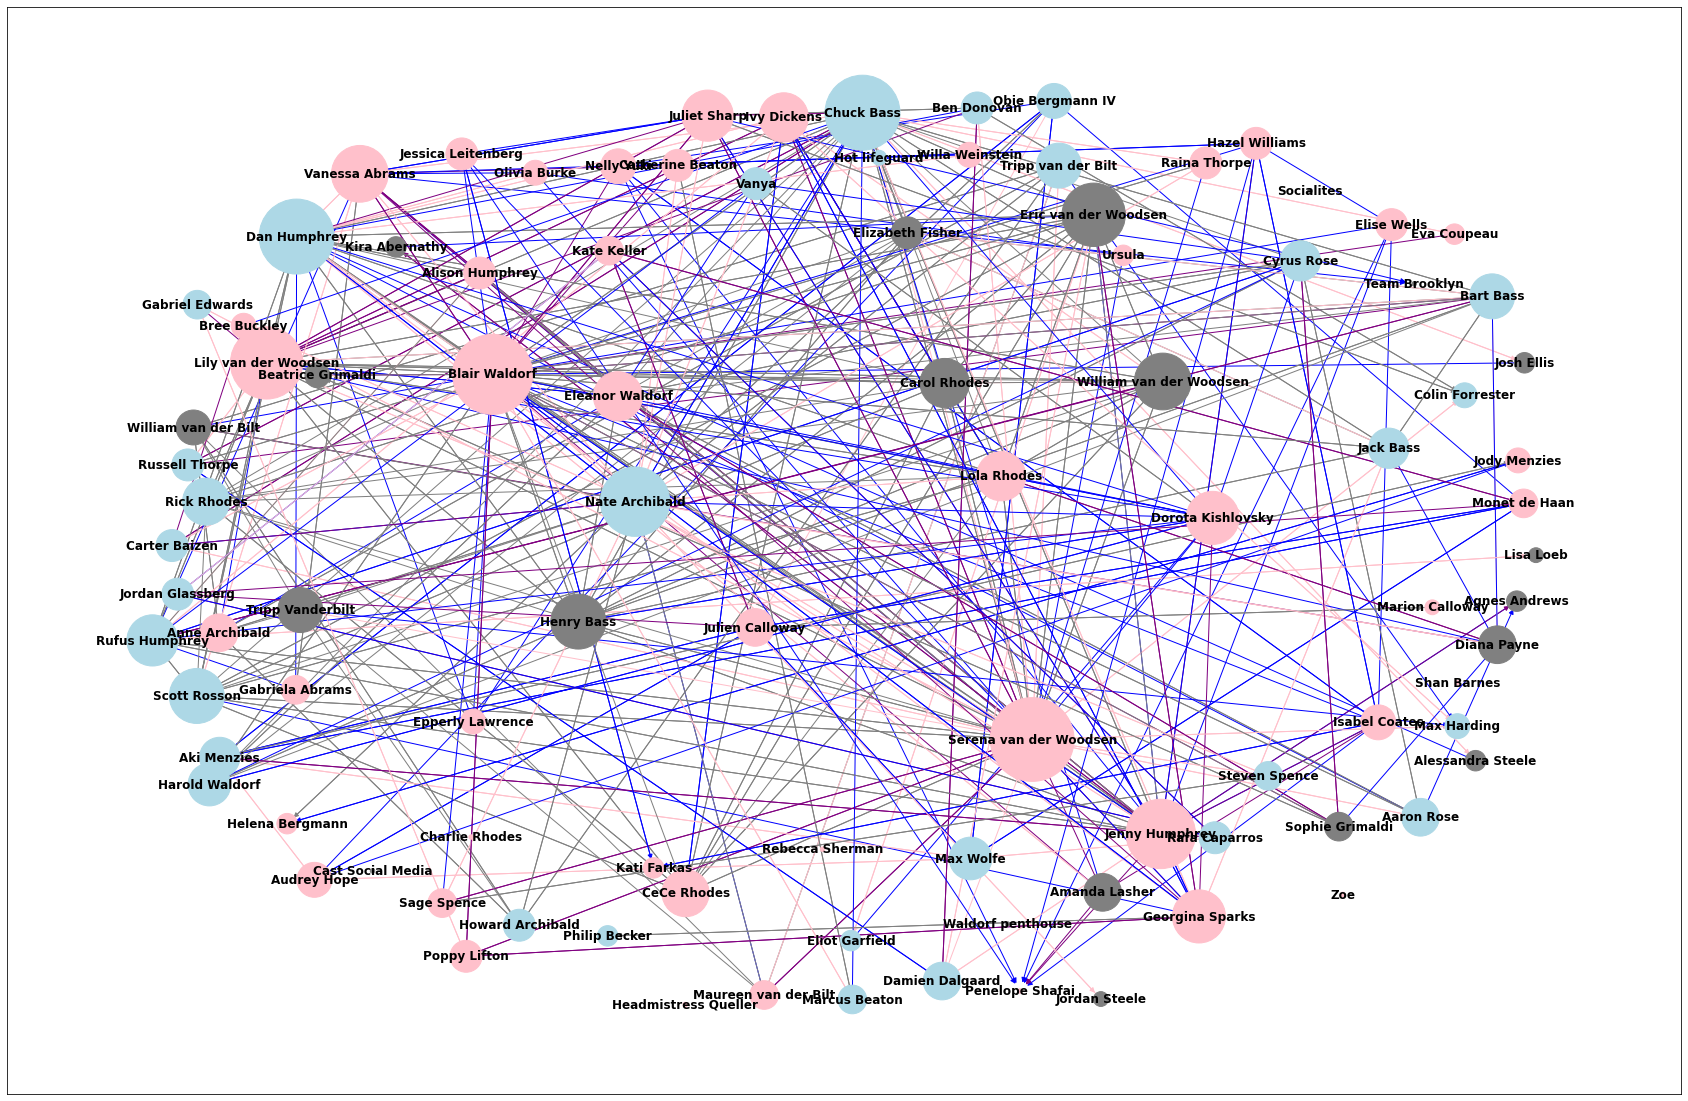

In [12]:
## create network with nodes and edges
edgeListFamily = []
edgeListRomances = []
edgeListFriends = []
edgeListEnemies = []


def createNetwork():

    edgeListFamily = []
    edgeListRomances = []
    edgeListFriends = []
    edgeListEnemies = []
    for i in range(len(listCharachters)):
        for j in DF['Family'][i]:
            if(j in listCharachters):
                edgeListFamily.append((listCharachters[i],j))

        for j in DF['Romances'][i]:
            if(j in listCharachters):
                edgeListRomances.append((listCharachters[i],j))

        for j in DF['Friends'][i]:
            if(j in listCharachters):
                edgeListFriends.append((listCharachters[i],j))

        for j in DF['Enemies'][i]:
            if(j in listCharachters):
                edgeListEnemies.append((listCharachters[i],j))


    fig, ax = plt.subplots()
    fig.set_size_inches(30,20)

    G = nx.DiGraph()
    G.add_nodes_from(listCharachters)
    G.add_edges_from(edgeListFamily)
    G.add_edges_from(edgeListRomances)
    G.add_edges_from(edgeListFriends)
    G.add_edges_from(edgeListEnemies)



    sizes = DF['size/Relastionship']
    gender = DF['gender/color']
    nodesizes = [int(s)*200+20 for s in sizes]
    


    pos = nx.spring_layout(G, k=10*1/np.sqrt(len(G.nodes())), iterations=20)
    nx.draw_networkx_nodes(G, pos=pos, node_size = nodesizes, node_color= gender )
    nx.draw_networkx_edges(G,pos=pos, width=1, edge_color=getEdgeColors(G.edges, edgeListFamily, edgeListRomances, edgeListFriends))
    nx.draw_networkx_labels(G,pos=pos, font_weight='bold',font_color='black')
    plt.show()
    
    
    return G  

#get edge colors
def getEdgeColors(edges, edgeListFamily, edgeListRomances, edgeListFriends):
    colors = []
    for e in edges:
        if e in edgeListFamily:
            colors.append("grey")
        elif e in edgeListRomances:
            colors.append("pink")
        elif e in edgeListFriends:
            colors.append("blue")
        else: 
            colors.append("purple")
    return colors
    

TotalNetwork = createNetwork()



## Info about graph

Number of edges in the directed graph is _591_
Number of edges in the Undirected graph is _357_

Comparing the number of edges in the undiredted and directed graph shows us that many of the relationship is registered on both nodes in a relatioship. This is easy to predict. It is more intrestig that not al charachters registered in a realationship with another charachter are registered the other way around. 

In [41]:

print("Number of edges in the directed graph is", TotalNetwork.number_of_edges())

totalNetworkUndirected = TotalNetwork.to_undirected()

#This used to work. The data has been used later in the project. See website for table. 
SortedG = sorted(nx.connected_components(totalNetworkUndirected), key= len)[:-10]
SortedG = [('Serena van der Woodsen', 69), ('Blair Waldorf', 64),('Chuck Bass', 54), ('Dan Humphrey' , 46), ('Lily van der Woodsen',44),
('Nate Archibald', 44), ('Jenny Humphrey', 39), ('Eric van der Woodsen', 33), ('Henry Bass',31), ('Rufus Humphrey',25)]

print("Number of edges in the Undirected graph is", totalNetworkUndirected.number_of_edges())

Number of edges in the directed graph is 591
Number of edges in the Undirected graph is 357


### Create Network for a subset of  nodes and charachters

This function is created to easier analyze groups of charachters (comunities) and a singlecharachter 

The network of each charachter gives us an unique insight to al their relationships and what kindof realationships it has to other charachters in the sosial network. We can see witch charachters has the mmost inflluence 

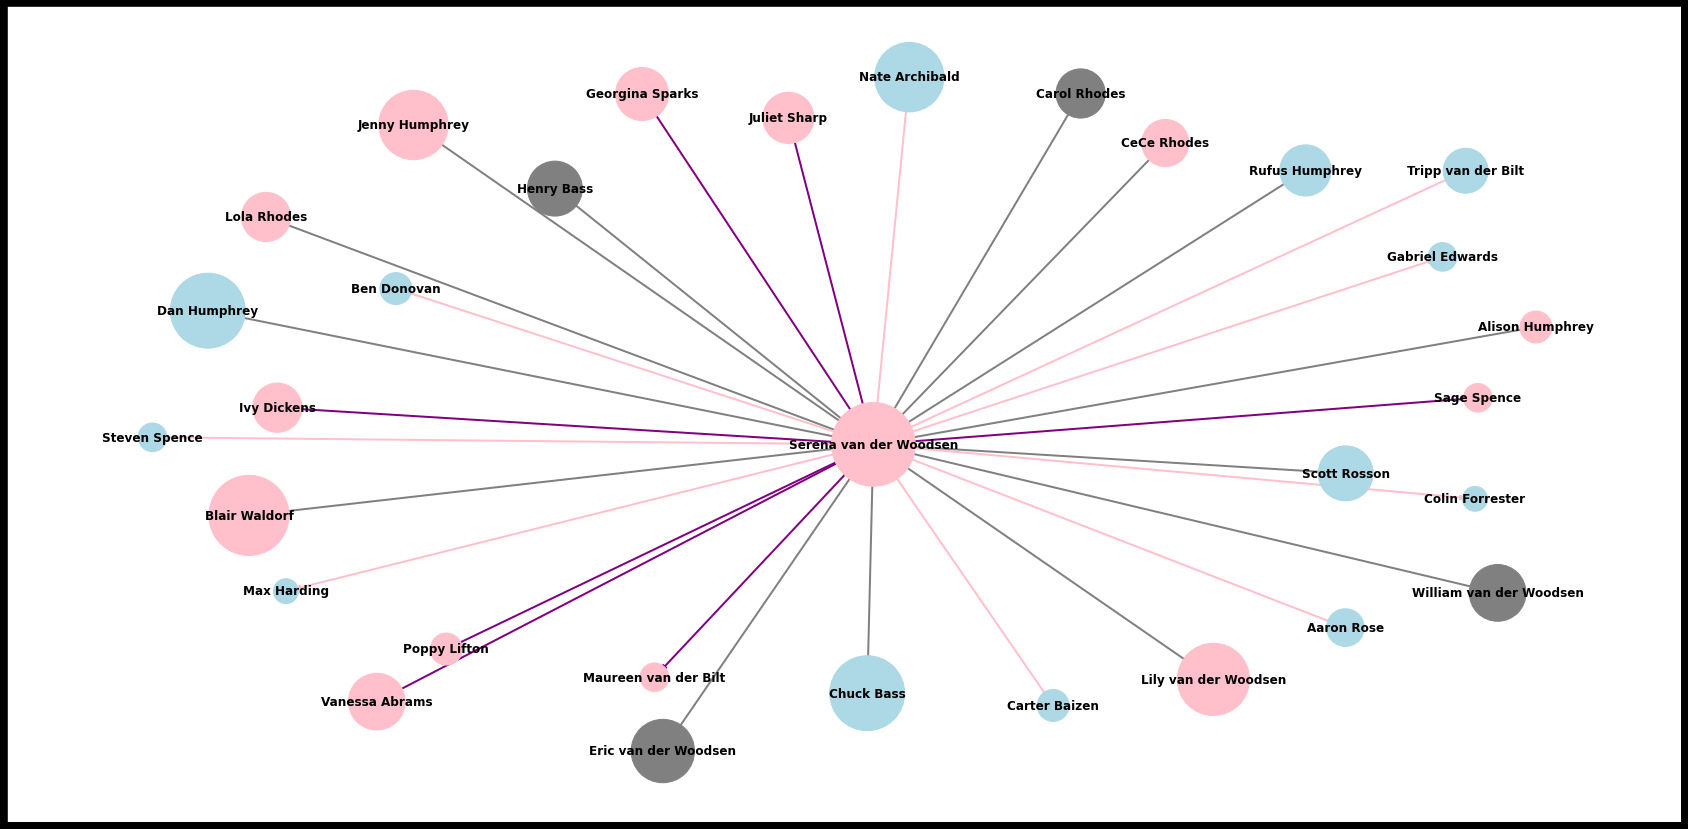

Number of edges in the Undirected graph is 30


<Figure size 432x288 with 0 Axes>

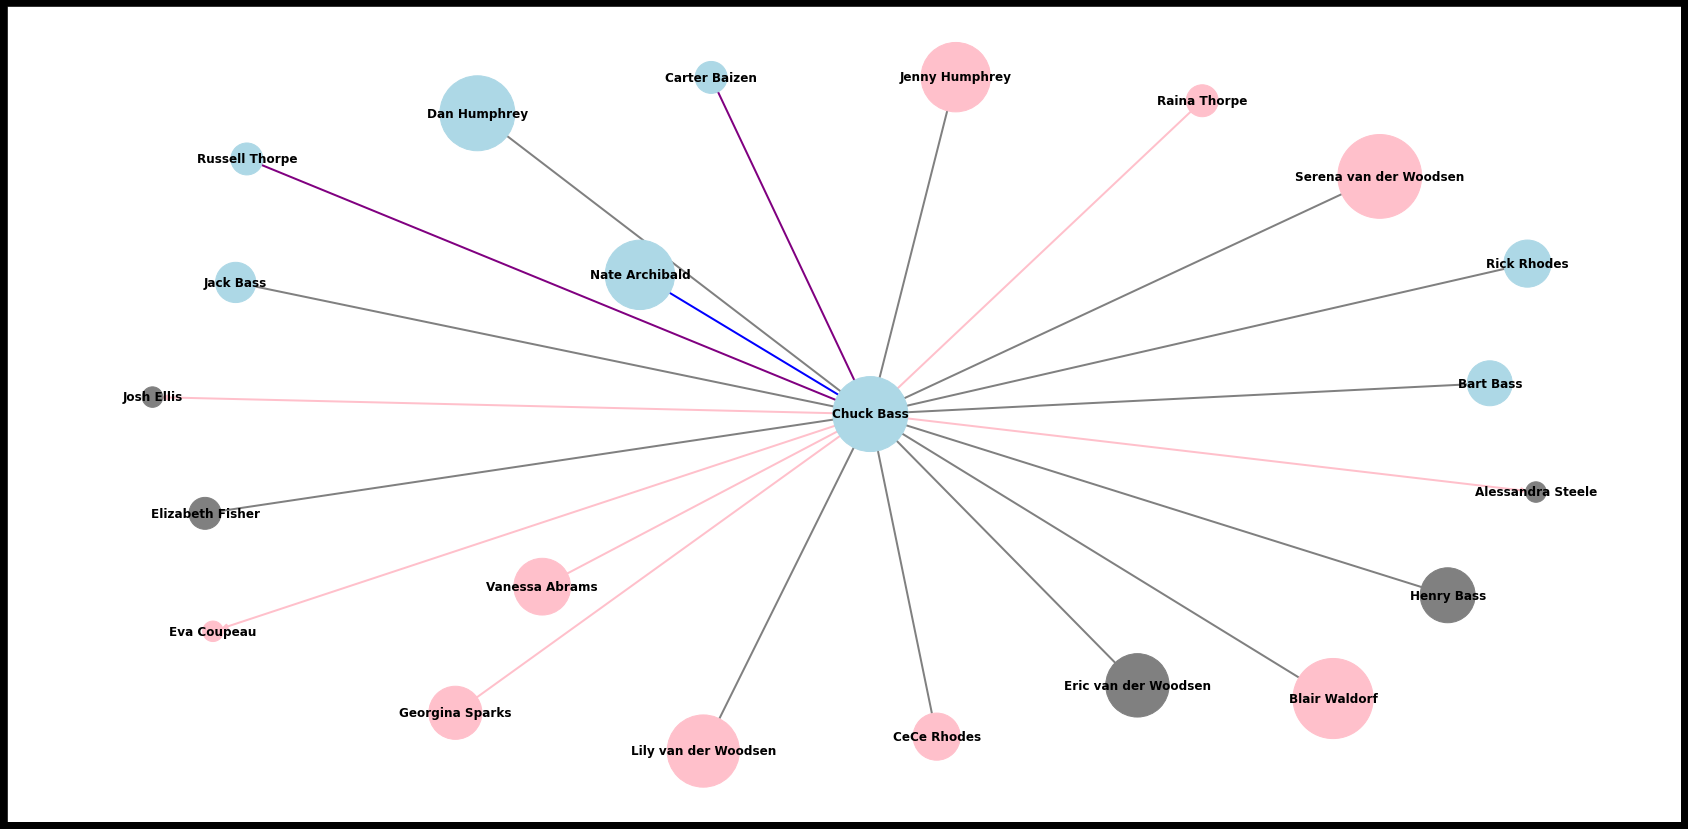

Number of edges in the Undirected graph is 21


<Figure size 432x288 with 0 Axes>

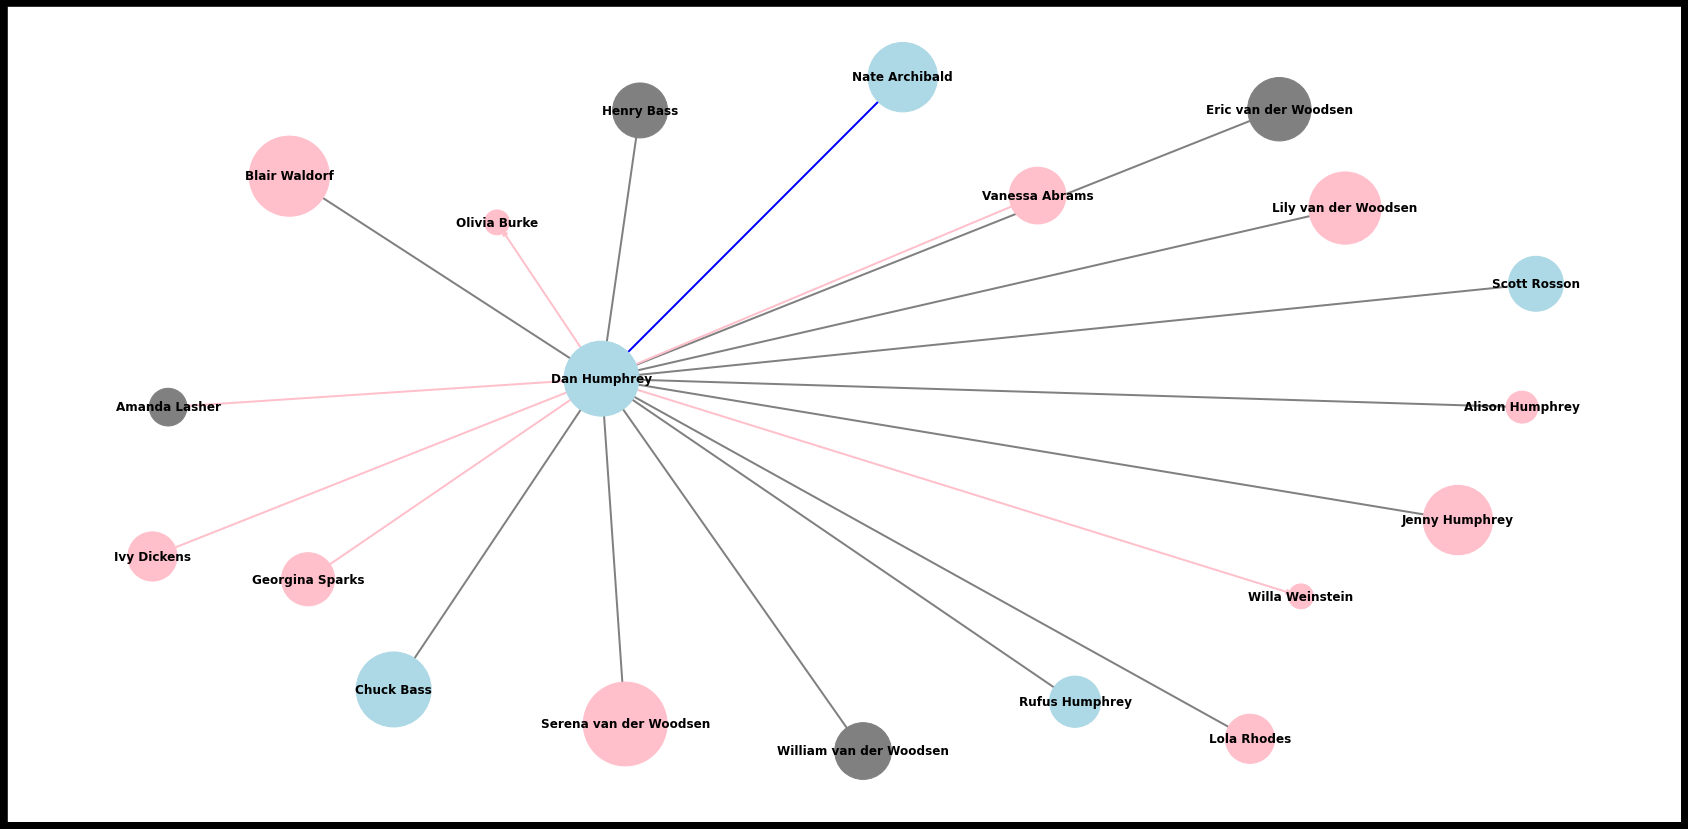

Number of edges in the Undirected graph is 19


<Figure size 432x288 with 0 Axes>

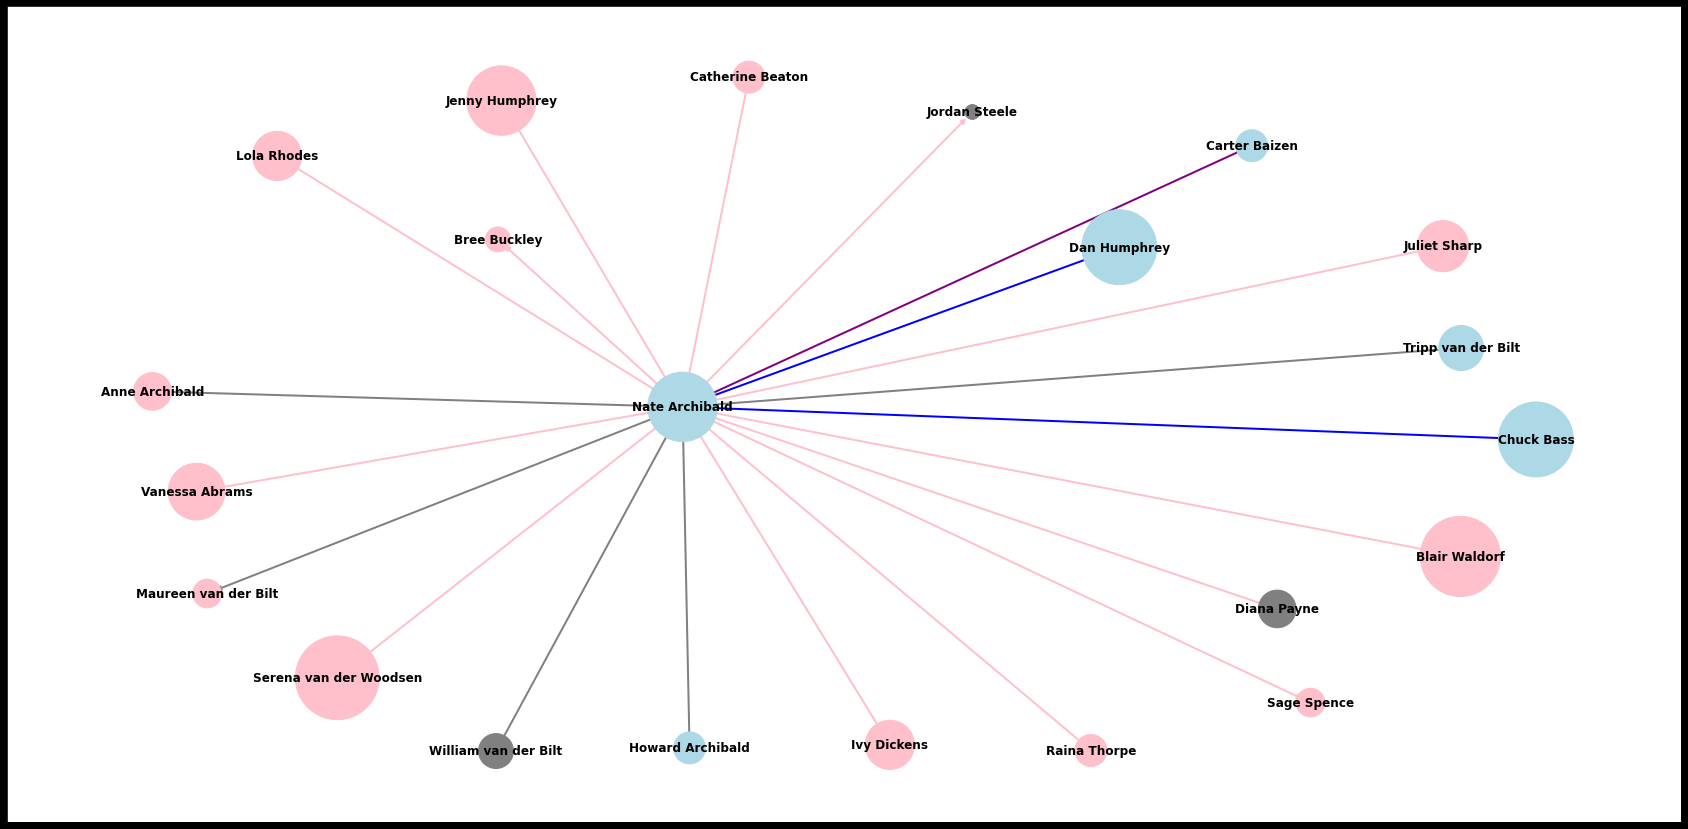

Number of edges in the Undirected graph is 21


<Figure size 432x288 with 0 Axes>

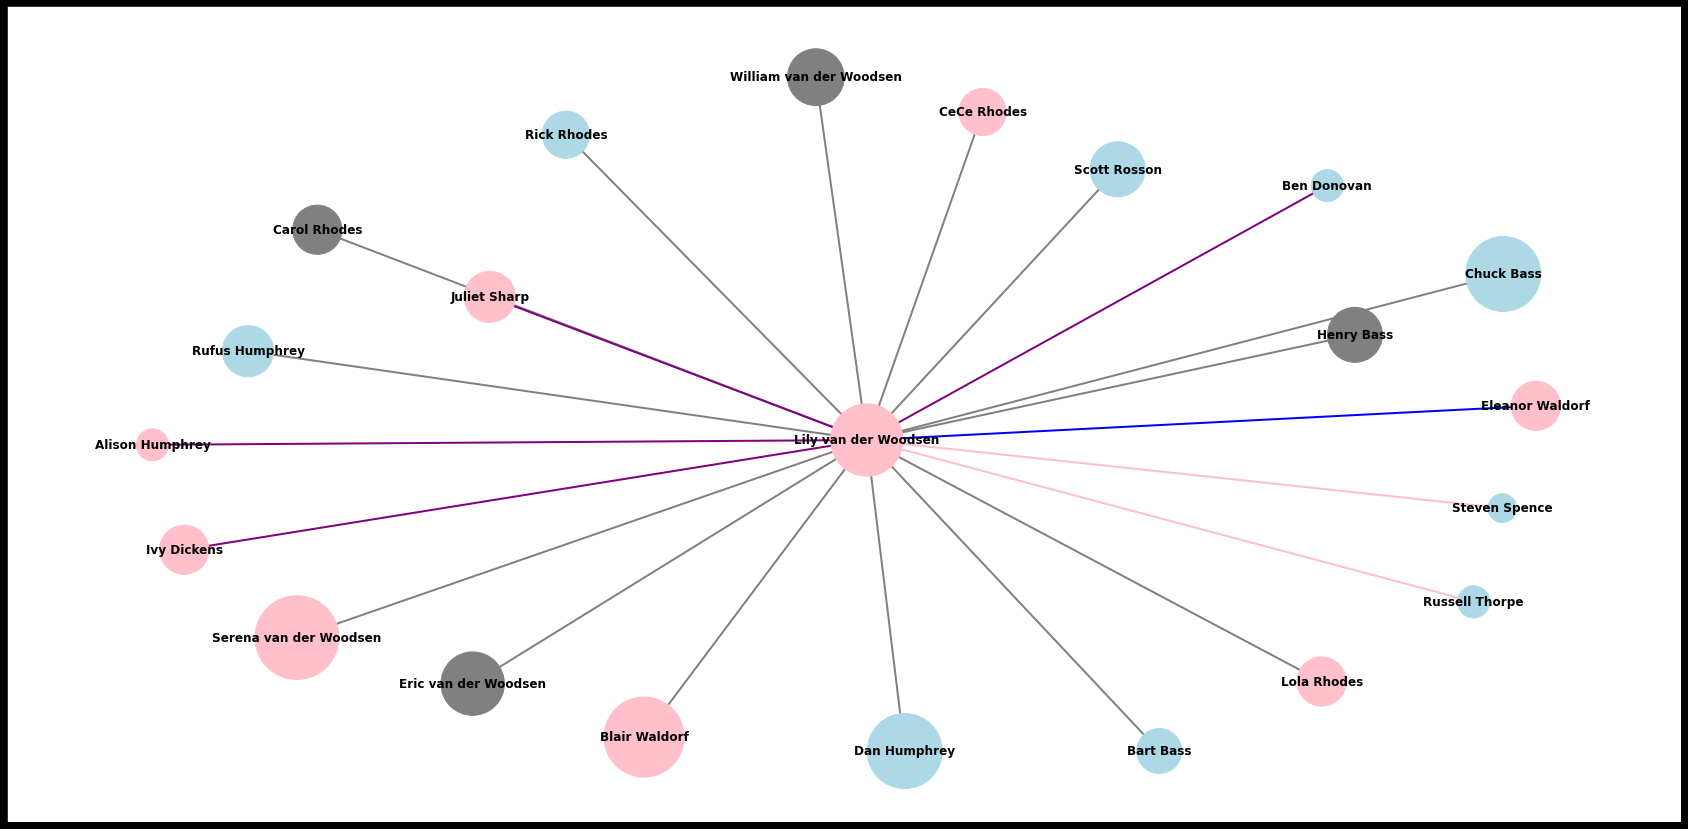

Number of edges in the Undirected graph is 21


<Figure size 432x288 with 0 Axes>

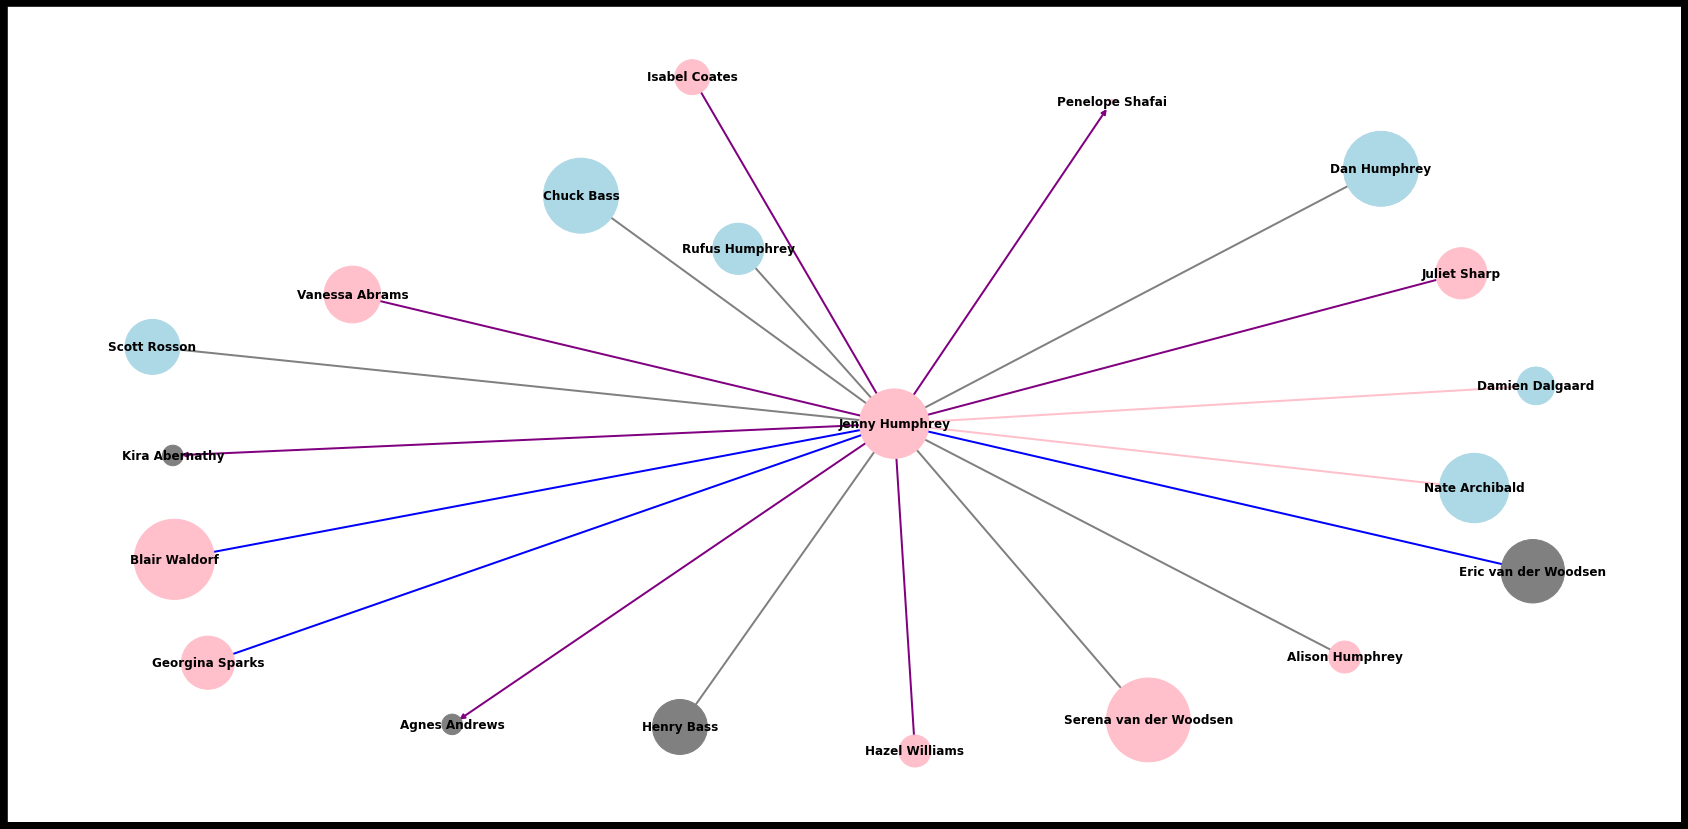

Number of edges in the Undirected graph is 19


<Figure size 432x288 with 0 Axes>

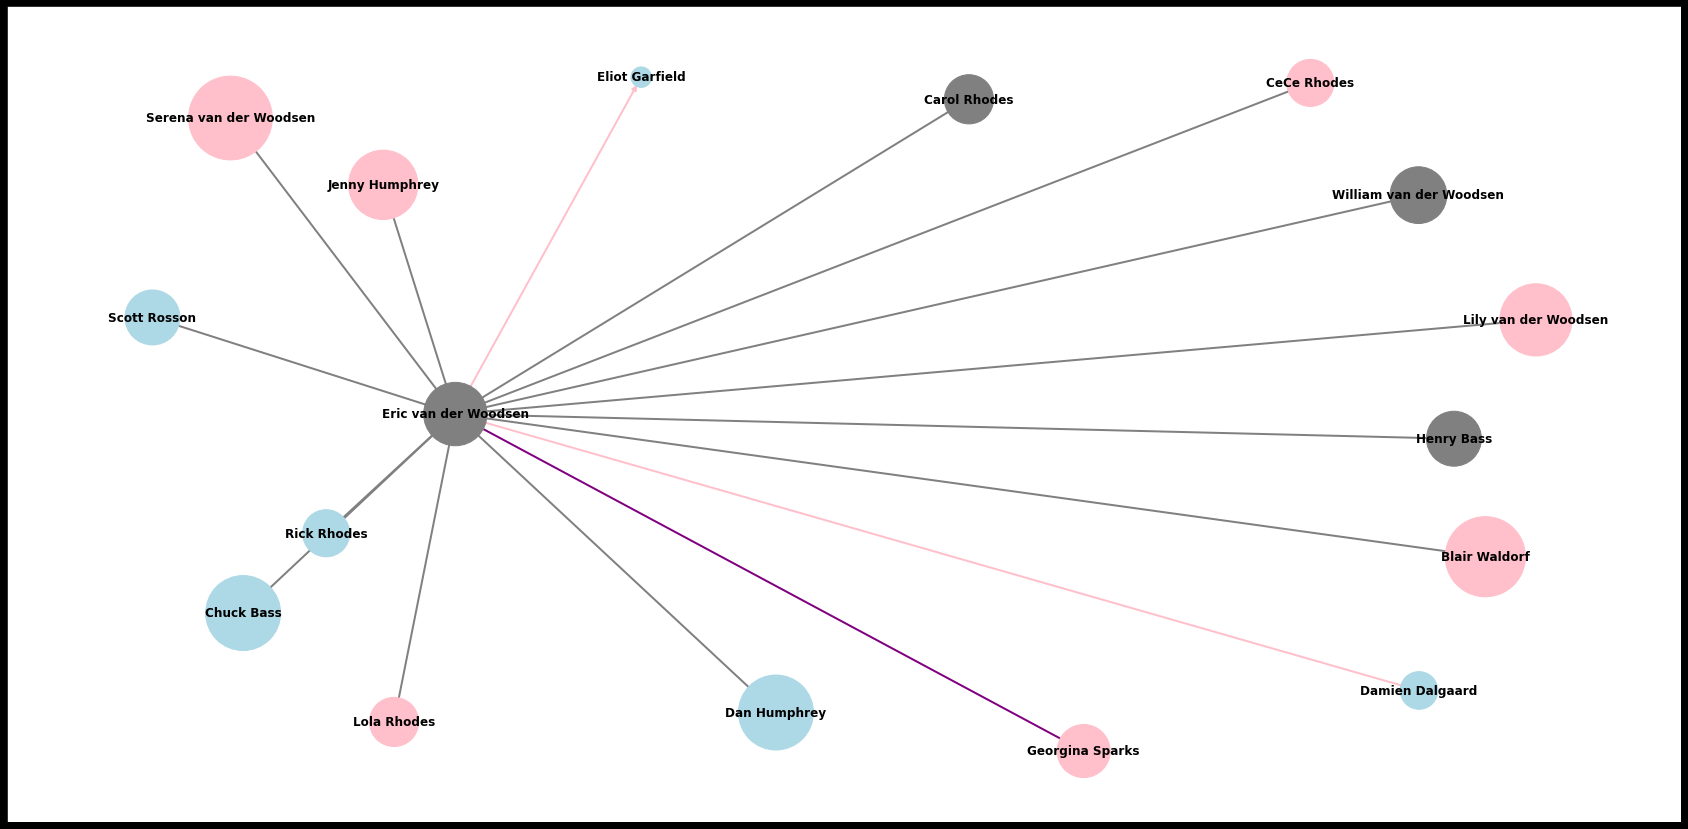

Number of edges in the Undirected graph is 16


<Figure size 432x288 with 0 Axes>

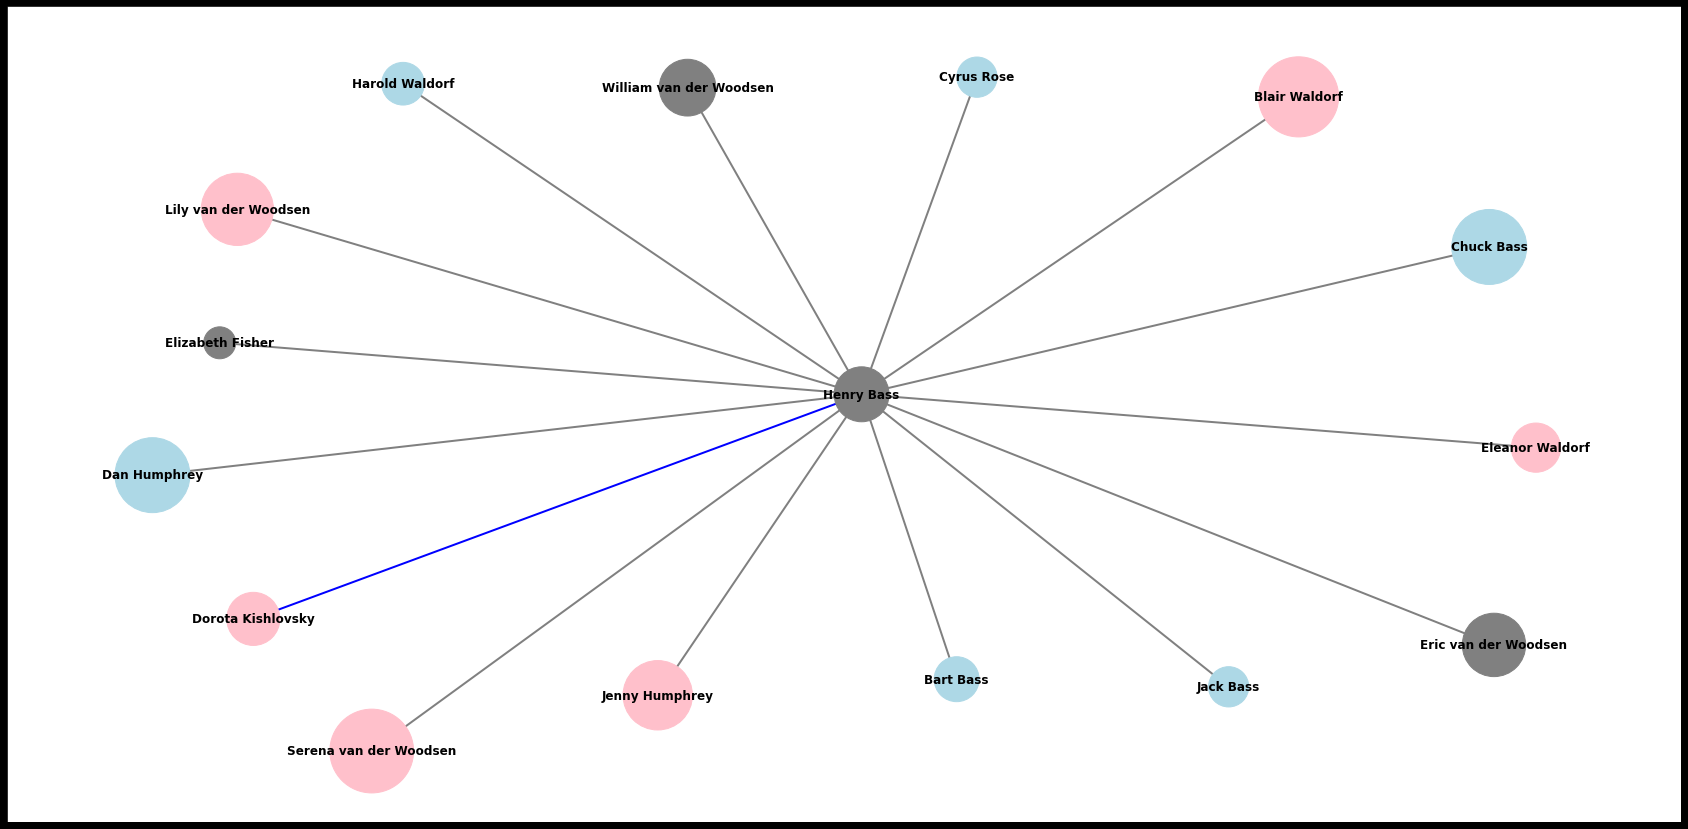

Number of edges in the Undirected graph is 15


<Figure size 432x288 with 0 Axes>

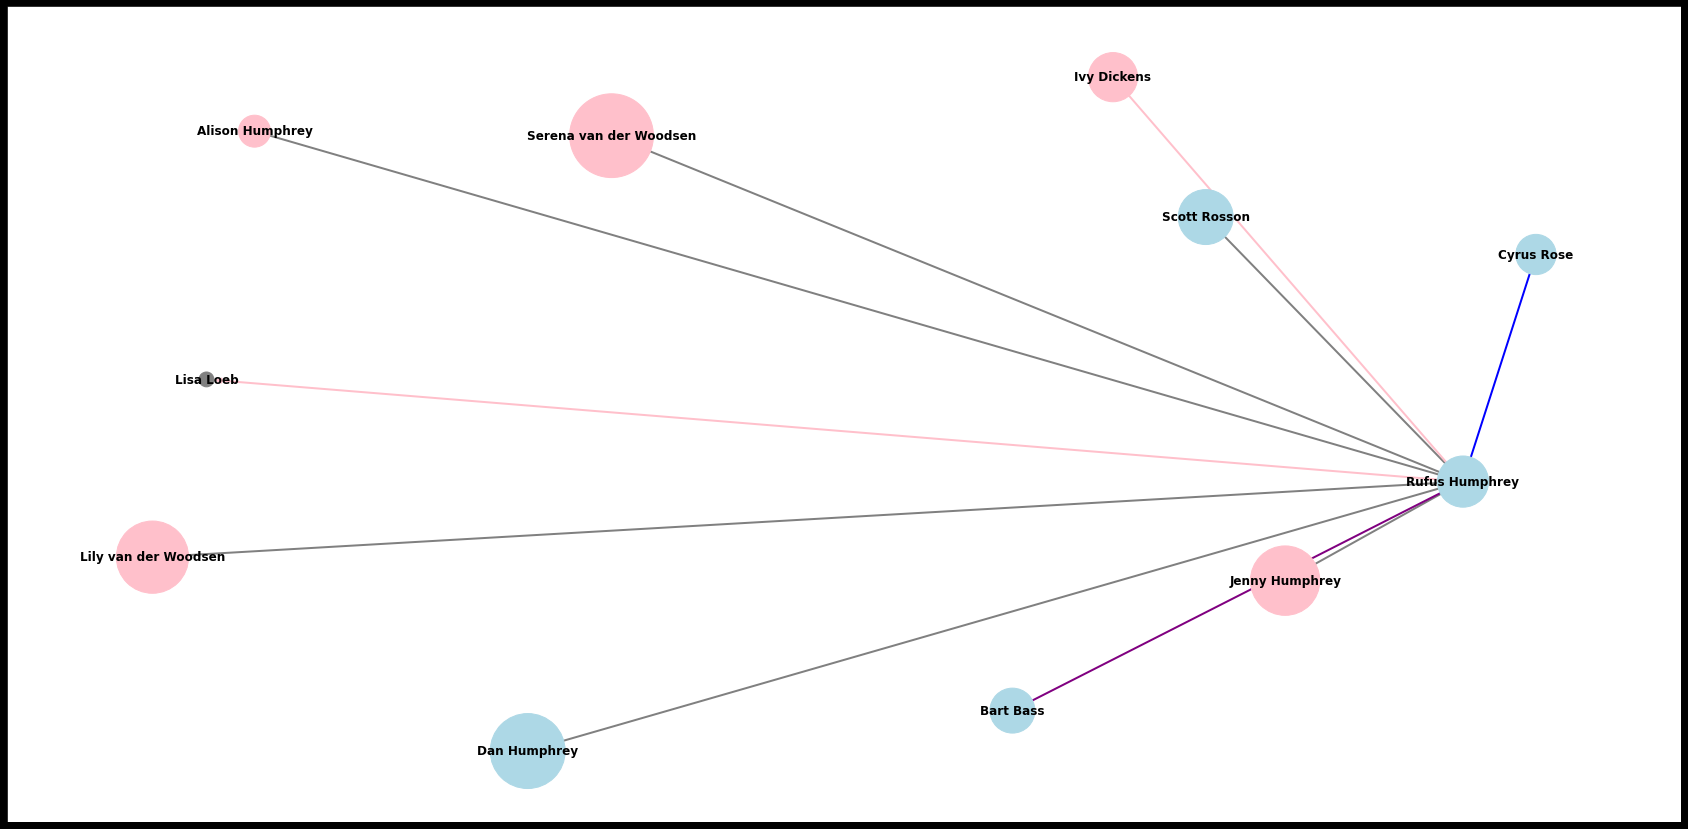

Number of edges in the Undirected graph is 10


<Figure size 432x288 with 0 Axes>

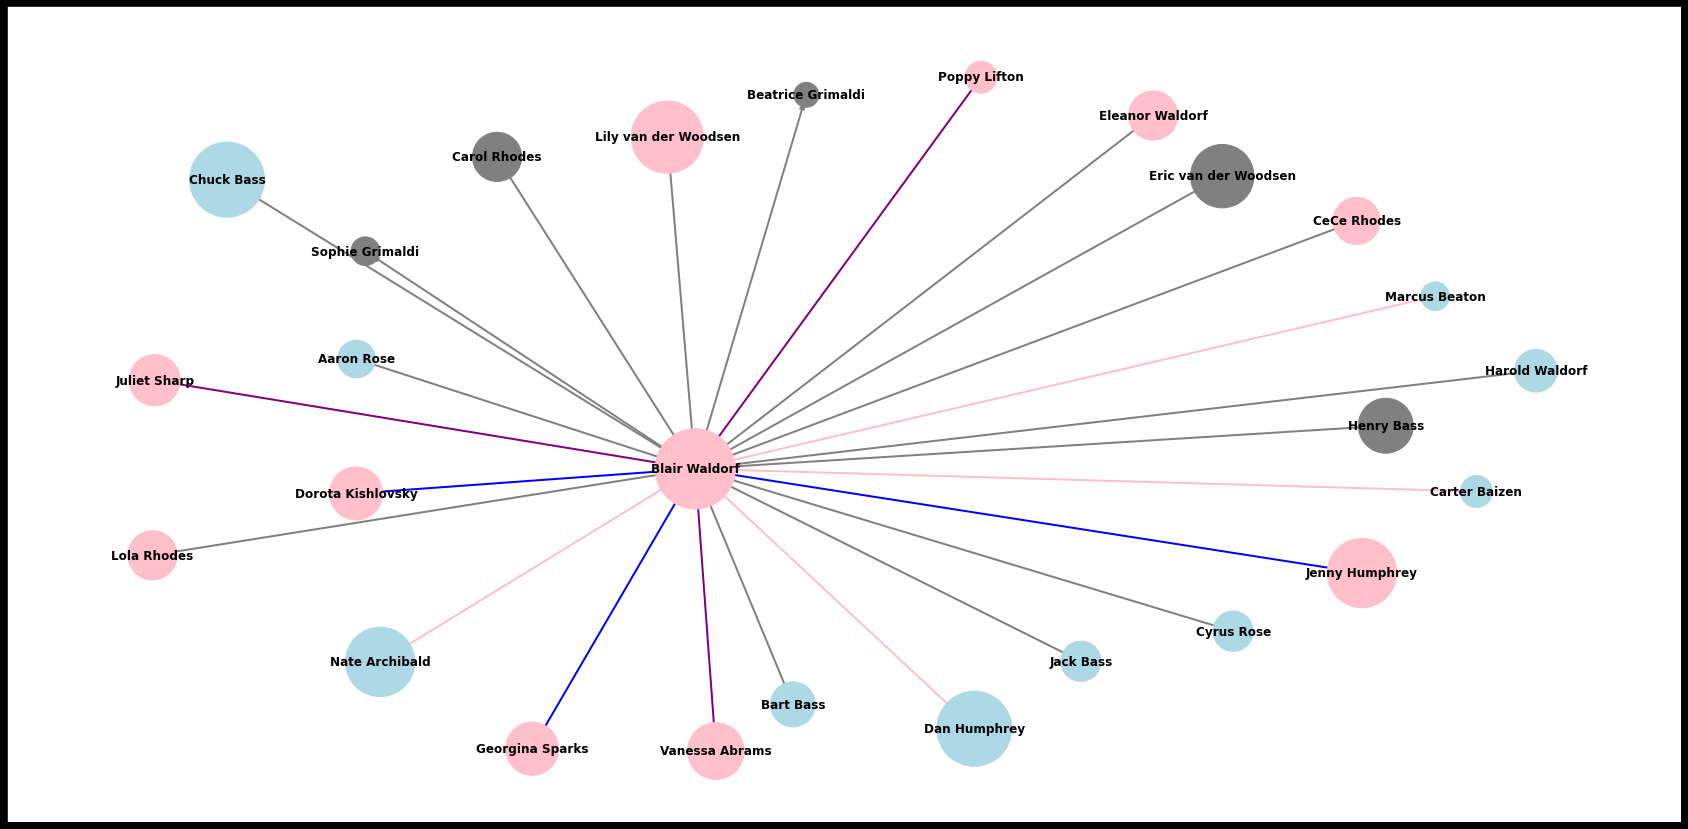

Number of edges in the Undirected graph is 25


<Figure size 432x288 with 0 Axes>

In [15]:
## Create network for one node with belonging neidgbors and edges

def createNetwork2(list):
    
    G = nx.DiGraph()
    
    edgeListFamily = []
    edgeListRomances = []
    edgeListFriends = []
    edgeListEnemies = []
    
    sizes = []
    gender = []
    for node in list:
        i = listCharachters.index(node)
        for j in DF['Family'][i]:
            if(j in listCharachters and j not  in G.nodes):
                G.add_node(j)
                edge = listCharachters[i],j
                if edge not in edgeListRomances or edgeListFriends or edgeListEnemies:
                    edgeListFamily.append((edge))
                    sizes.append(getSize(j))
                    gender.append(getGender(j))

        for j in DF['Romances'][i]:
            if(j in listCharachters and j not in G.nodes):
                G.add_node(j)
                edge = listCharachters[i],j
                if edge not in edgeListFamily or edgeListFriends or edgeListEnemies:
                    edgeListRomances.append((edge))
                    sizes.append(getSize(j))
                    gender.append(getGender(j))

        for j in DF['Friends'][i]:
            if(j in listCharachters and j not in G.nodes):
                G.add_node(j)
                edge = listCharachters[i],j
                if edge not in edgeListFamily or edgeListRomances or edgeListEnemies:
                    edgeListFriends.append((edge))
                    sizes.append(getSize(j))
                    gender.append(getGender(j))

        for j in DF['Enemies'][i]:
            if(j in listCharachters and j not in G.nodes):
                G.add_node(j)
                edge = listCharachters[i],j
                if edge not in edgeListFamily or edgeListFriends or edgeListRomances:
                    edgeListEnemies.append((edge))
                    sizes.append(getSize(j))
                    gender.append(getGender(j))
        
        #If we only want the network of one node
        if len(list) == 1:
            sizes.append(DF['size/Relastionship'][i])
            gender.append(DF['gender/color'][i])

    fig, ax = plt.subplots()
    fig.set_size_inches(30,15)
    fig.set_facecolor('black')
    
    G.add_edges_from(edgeListFamily)
    G.add_edges_from(edgeListRomances)
    G.add_edges_from(edgeListFriends)
    G.add_edges_from(edgeListEnemies)

    nodesizes = [int(s)*200+20 for s in sizes]
    
    pos = nx.spring_layout(G, k=6*1/np.sqrt(len(G.nodes())), iterations=20)
    nx.draw_networkx_nodes(G, pos=pos, node_size = nodesizes, node_color= gender )
    nx.draw_networkx_edges(G,pos=pos, width=2, edge_color=getEdgeColors(G.edges, edgeListFamily, edgeListRomances, edgeListFriends))
    nx.draw_networkx_labels(G,pos=pos, font_weight='bold',font_color='black')
    plt.show()
    fig=plt.figure()

    fig.savefig(list[0]+'.png', bbox_inches='tight')
    
    H = G.to_undirected()
    
    print("Number of edges in the Undirected graph is", H.number_of_edges())
    

charachters10 = ['Serena van der Woodsen', 'Chuck Bass', 'Dan Humphrey','Nate Archibald','Lily van der Woodsen','Jenny Humphrey','Eric van der Woodsen','Henry Bass','Rufus Humphrey', 'Blair Waldorf']

for c in charachters10:
    createNetwork2([c])



### Gets Network for family 

The network of each family and the charachter the families has a relationship to. We can see that the Humphrey family is the family with the most social influence shortly followed by the van der Woodsen family. 

Number of edges in Van der Woodsen: 48 
Number of edges in Humprey: 49
Number of edges in Bass: 41

Van der Woodsen


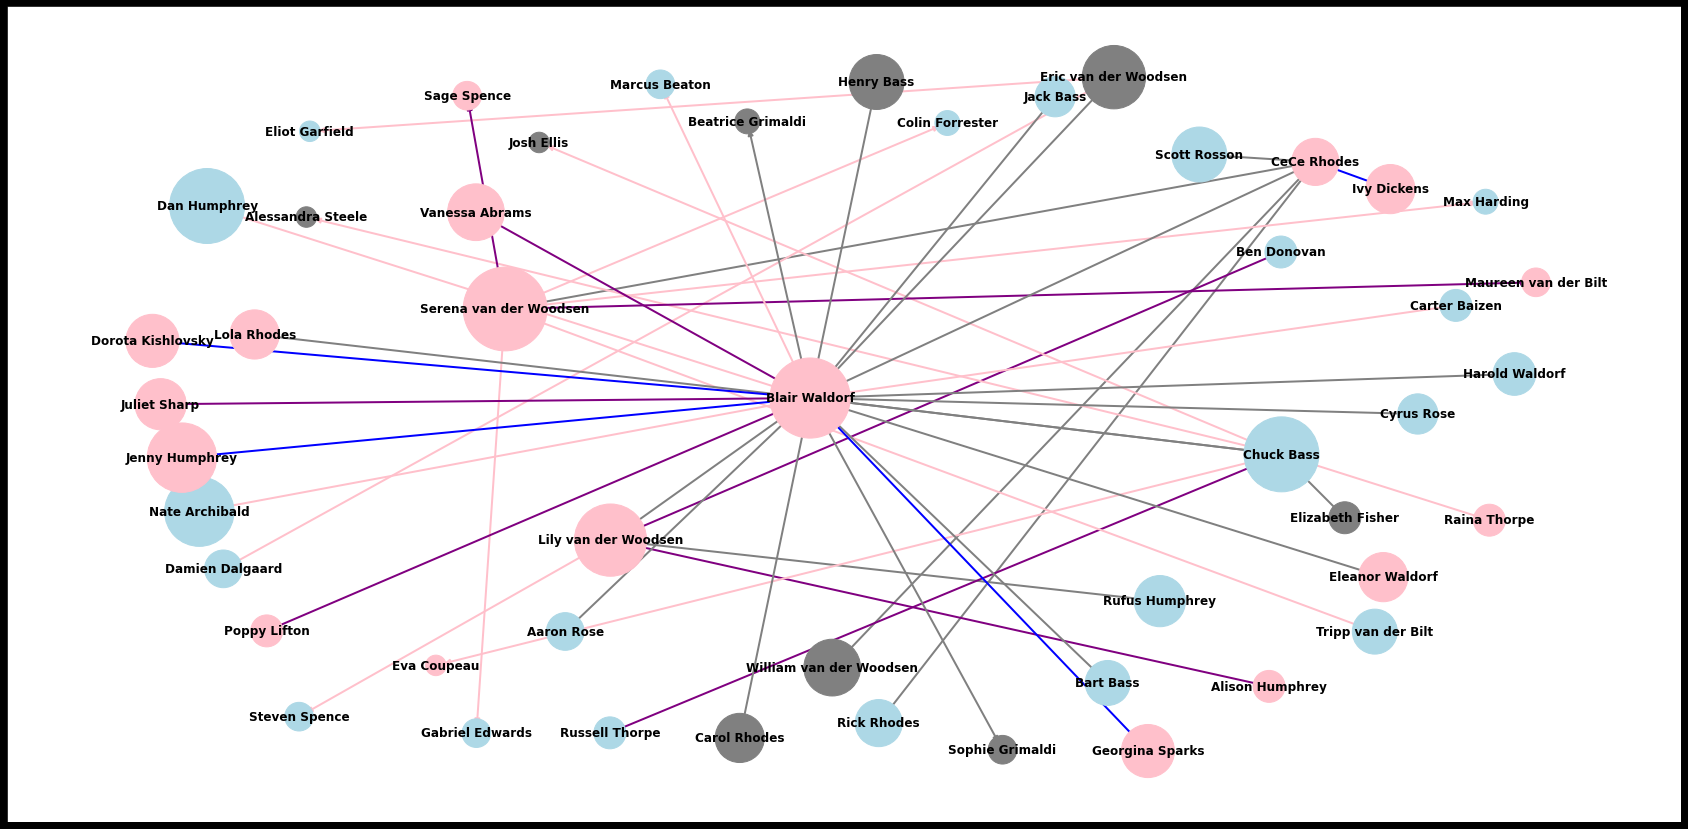

Number of edges in the Undirected graph is 48
Humphrey


<Figure size 432x288 with 0 Axes>

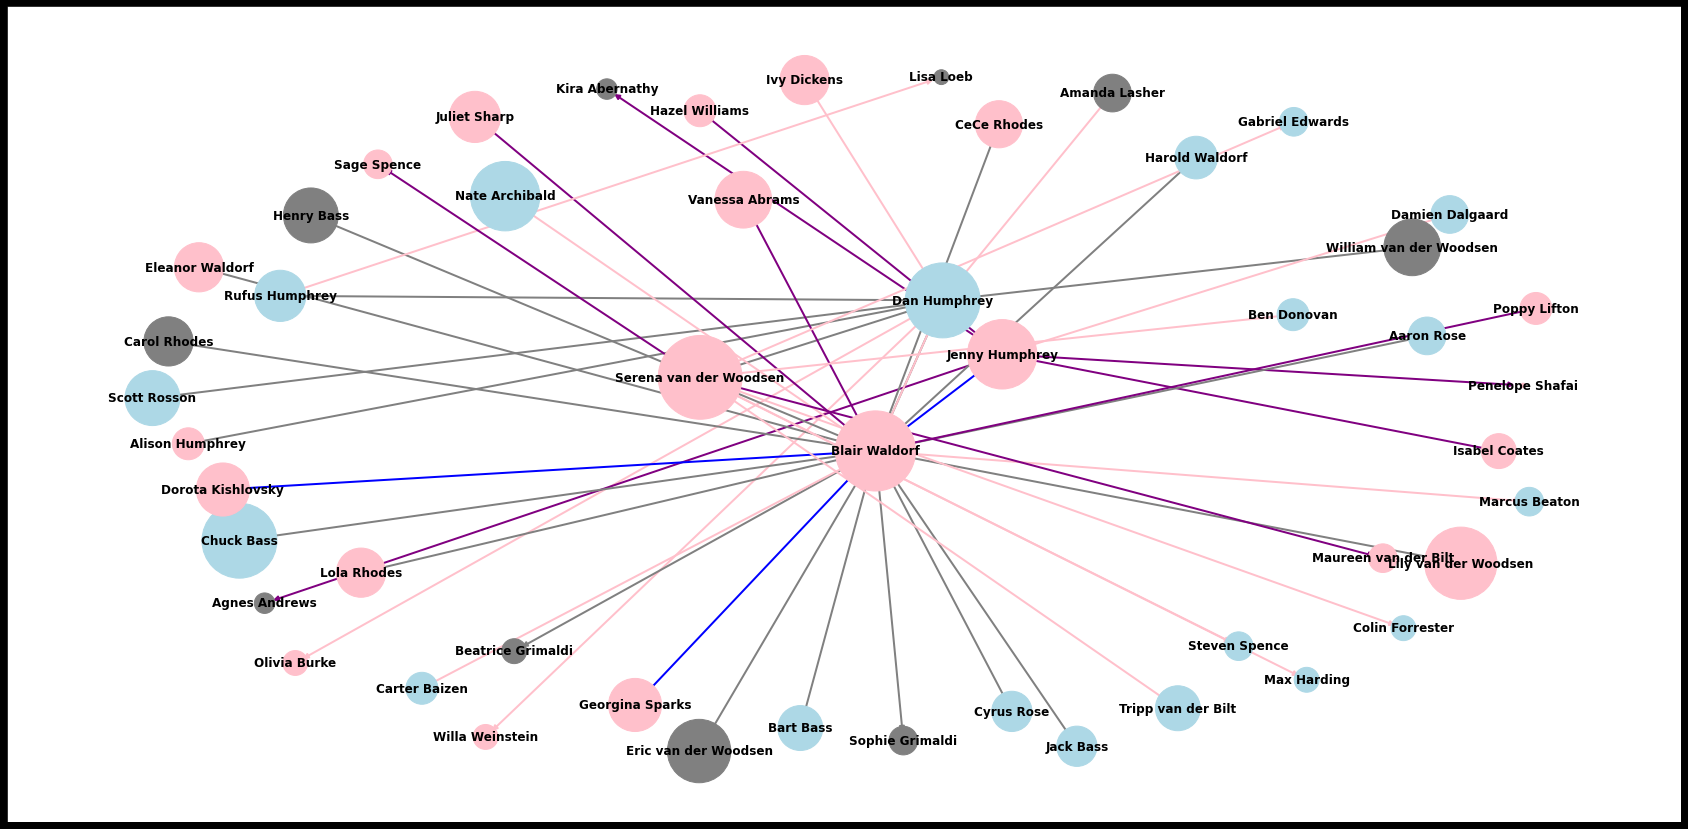

Number of edges in the Undirected graph is 49
Bass


<Figure size 432x288 with 0 Axes>

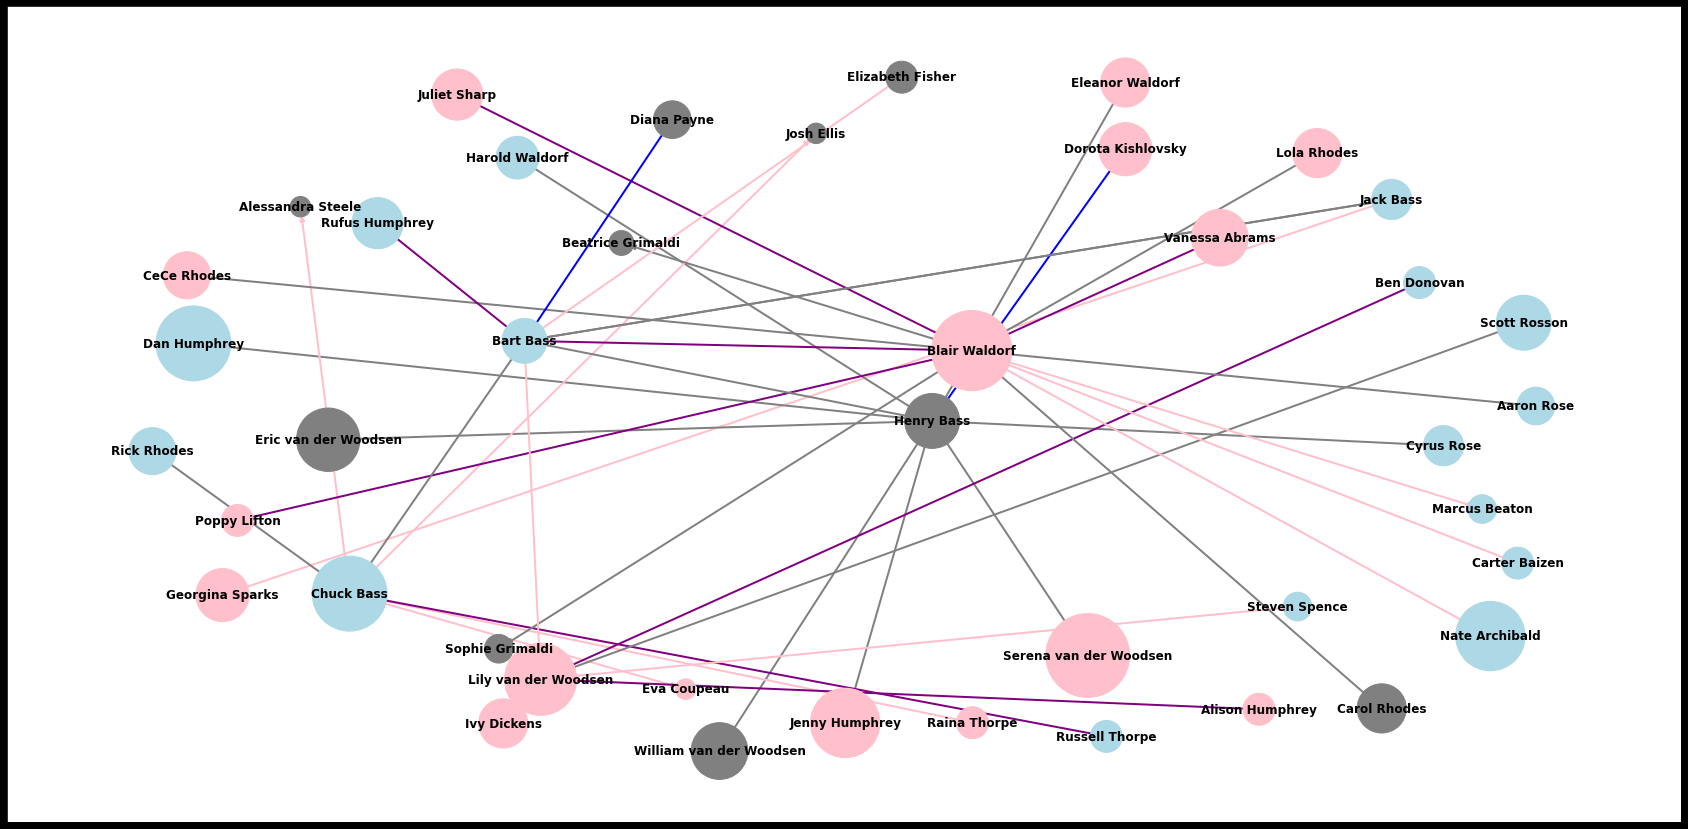

Number of edges in the Undirected graph is 41


<Figure size 432x288 with 0 Axes>

In [16]:
VanDerWoodsen = list(set(CharacterList('https://gossipgirl.fandom.com/wiki/Category:Van_der_Woodsen_family')))
Humphrey = list(set(CharacterList('https://gossipgirl.fandom.com/wiki/Category:Humphrey_family')))
Bass = list(set(CharacterList('https://gossipgirl.fandom.com/wiki/Category:Bass_Family')))
VanDerWoodsen.remove('Chuck–Serena relationship')
Humphrey.remove('Milo Sparks')
Bass.remove('The Bass Family')
Bass.remove('Chuck–Serena relationship')

print('Van der Woodsen')
createNetwork2(VanDerWoodsen)
print('Humphrey')
createNetwork2(Humphrey)
print('Bass')
createNetwork2(Bass)





### 10 most conected charachters

The 10 most conected charachter are the oneswith the most social influence in the gossip girl social network. Serena van der Woodsen and Blair Waldorf has the most influence. They are also known as the queen bees. This will be used inn the further analyses to see how and who they influence. 

In [50]:


DF2 = pd.DataFrame(columns=['Character', 'Degree'])
top10 = []
degree = []
for c in SortedG[:10]:
    top10.append(c[0])
    degree.append(c[1])
    
DF2['Character'] = top10 
DF2['Degree'] = degree

DF2


Character  Degree
0  Serena van der Woodsen      69
1           Blair Waldorf      64
2              Chuck Bass      54
3            Dan Humphrey      46
4    Lily van der Woodsen      44
5          Nate Archibald      44
6          Jenny Humphrey      39
7    Eric van der Woodsen      33
8              Henry Bass      31
9          Rufus Humphrey      25

### Discussion of results 

The Network analyses has given us insight in how the charachters is conected and who has the most influence in the social network. 

## Text analyses

In this section we want to use the information we have collected so far to find out how and who the most influencial and conected charachters influence the social network.

To accomplish this we will use wordclouds from the tf_idf of the top 10 most connected charachters from the description of the charachters influence in each episode, and also sentiment analyses of the description of the charachters influence in each episode

In [58]:

charachterDict = {}
for character in top10:
    charachterDict[character] = getCleanText(character)
    i = listCharachters.index(character)
    DF['description'][i] =charachterDict[character] 

DF.to_csv('Data.csv', index=False)


#### the top 10 most conected components 



## wordCloud

We use wordcloud of the desection of the characters to help us get a insight in who they influence with the most.

To create the wordcloud Tf_idf has been used to figure out witch word are uniquely  used often for the charachter. 
Termcount gets the termcount and collects them in a dictionary where the unique word is the key. Collects the text in one collection using nltk.  idf gets the idf of each word using buildtin idf library. Finds the tc_idf for each charachetr and uses the wordcloud library to create wordclouds.

In each charachter we can see the words that is uniquely used by each charachter. The wordcloud gives us a overview of who the charachter interact the most withtroughout the seasons. We can e.g see that Serena van der Woodsen often interact with Dan and Blair and influence them troughout the differet seasons.  


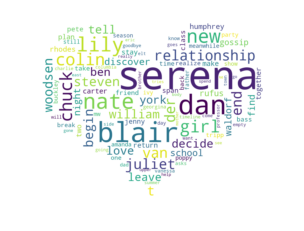

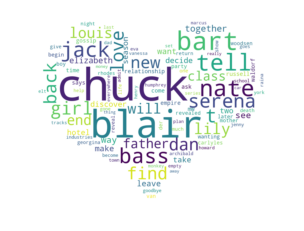

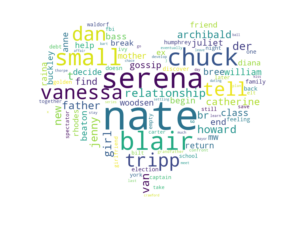

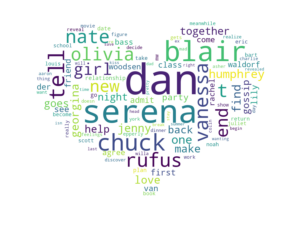

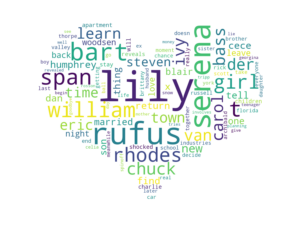

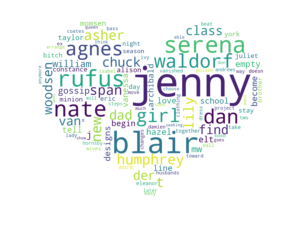

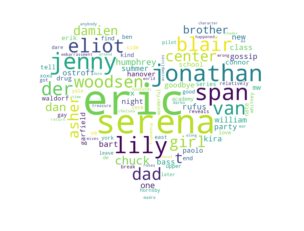

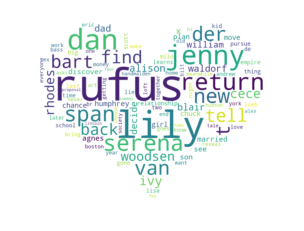

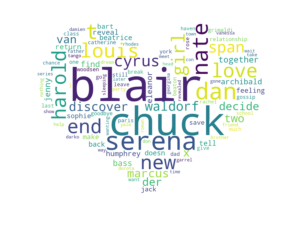

In [52]:
kiss_mask = np.array(Image.open("kiss4.png"))

def grey_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(230,100%%, %d%%)" % np.random.randint(30,60))


def term_count(titleList):
    termCount = {}
    for word in titleList:
        if word in termCount:
            termCount[word] +=1
        else: 
            termCount[word]= 1 

    return termCount

collectionText = nltk.TextCollection([charachterDict['Serena van der Woodsen'], charachterDict['Chuck Bass'], charachterDict['Nate Archibald'],charachterDict['Dan Humphrey'],charachterDict['Lily van der Woodsen'], charachterDict['Jenny Humphrey'], charachterDict['Eric van der Woodsen'], charachterDict['Henry Bass'],charachterDict['Rufus Humphrey'], charachterDict['Blair Waldorf']])



def idf(text):
    idf= {}
    for word in text:
        idf[word] = text.idf(word)
    return idf
        

def tc_idf(title):
    idfs = idf(collectionText)
    tc_idf= {}
    for word in charachterDict[title]:
        tc_idf[word] = int(math.ceil(idfs[word])) * term_count(charachterDict[title])[word]
    return tc_idf

Serena_tc_idf= tc_idf('Serena van der Woodsen')
Chuck_tc_idf= tc_idf('Chuck Bass')
Nate_tc_idf= tc_idf('Nate Archibald')
Dan_tc_idf= tc_idf('Dan Humphrey')
Lily_tc_idf= tc_idf('Lily van der Woodsen')
Jenny_tc_idf= tc_idf('Jenny Humphrey')
Eric_tc_idf= tc_idf('Eric van der Woodsen')
#Henry_tc_idf= tc_idf('Henry Bass')
Rufus_tc_idf= tc_idf('Rufus Humphrey')
Blair_tc_idf= tc_idf('Blair Waldorf')
tc_idfs = [Serena_tc_idf, Chuck_tc_idf, Nate_tc_idf, Dan_tc_idf,Lily_tc_idf, Jenny_tc_idf,Eric_tc_idf, Rufus_tc_idf, Blair_tc_idf]
        
for tcidf in tc_idfs: 
  
    strng = ""
    for key,value in tcidf.items():
        strng+= ((key+ " ") * value)
    
    wordcloud = WordCloud(max_words=100, background_color="white", mask=kiss_mask, width =300, height = 200 , random_state=1, collocations=False).generate(strng)
    #wordcloud.recolor(color_func =pink_color_func, random_state = 3)
    img=plt.imshow(wordcloud, interpolation="bilinear")
    #plt.figure(figsize=(20,20), facecolor="k")

    plt.axis("off")
    plt.show()

## Sentiment analyses 

We chose to do a sentiment analysis because we wanted to analyze textual data and based on that, classify the results as positive, negative or neutral sentiments. We used the character wikipage, which describes each character in the series, in the sentiment analysis. 
We can think of the compound as a correlation. This means that is you hav a compound score of 1 it indicates that it is a highly positive sentiment and if you have a compound score of -1 it indicates that it is a highly negative sentiment. Because we used a description of the character in the analysis, the compound result will then show how negagtive or positive this character is portrayed in the TV series. As you can see, Serena Van Der Woodsen has a negative compound score, so her description has been very negative, and it comes from things you do and experience. 

The three other scores are the underlying sentiments which will account for the compound result.

When looking at the sentiment analysis that shows the negative sentiment scores for each character, Dan and Chuck, as well as Serena scores pretty high. But in contrast to Serena, Dan and Chuck also score high in when looking at the graph which shows the positive sentiment scores for each character

In [53]:
sia = SentimentIntensityAnalyzer()
NegPosComNeu = {}

for charachter in top10: 
    url =  requests.get(f"https://gossipgirl.fandom.com/wiki/{charachter}#Television_Series")
    soup = BeautifulSoup(url.text)

    infoBox = soup.findAll('div',{'class':'main-container'})
    infoBox = soup.findAll('div',{'class':'resizable-container'})
    infoBox = soup.findAll('div',{'class':'page has-right-rail'})
    infoBox = soup.findAll('div',{'class':'page-content'})
    infoBox = soup.findAll('p')[3:]
    list = []
    sentences = re.split('[\.\?\!]\s*', str(infoBox))
    for sentence in sentences:
        letters_only = re.sub("[^a-zA-Z]"," ",str(sentence))

        text = re.sub(r'\<.*?\>', '', letters_only)
        text = re.sub(r'\{\{.*?\}\}', '', text)
        text = re.sub(r'\[\[.*?\]\]', '', text)
        text = text.lower()
        text_tokens = word_tokenize(text)
        tokens = [word.lower() for word in text_tokens]
        tokens = [word for word in text_tokens if not word in stopwords.words()]
        removeList = ['p', 'a', 's', 'href',  'wiki']
        tokens = [word for word in text_tokens if not word in removeList]

        strng = " ".join(tokens)


        list.append(strng)
    sumC = 0 
    sumN = 0
    sumNeu = 0
    sumP = 0
    for sentence in list: 
        sentiment_dict = sia.polarity_scores(sentence)
        sumC += sentiment_dict['compound']
        sumN += sentiment_dict['neg']
        sumNeu += sentiment_dict['neu']
        sumP += sentiment_dict['pos']

    NegPosComNeu[charachter] = [sumC, sumN, sumNeu, sumP ]



<BarContainer object of 10 artists>

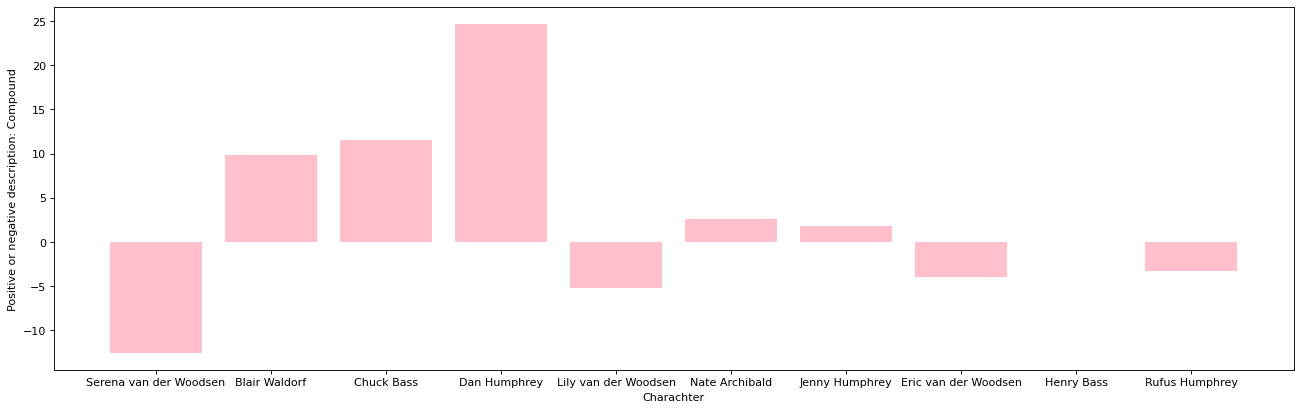

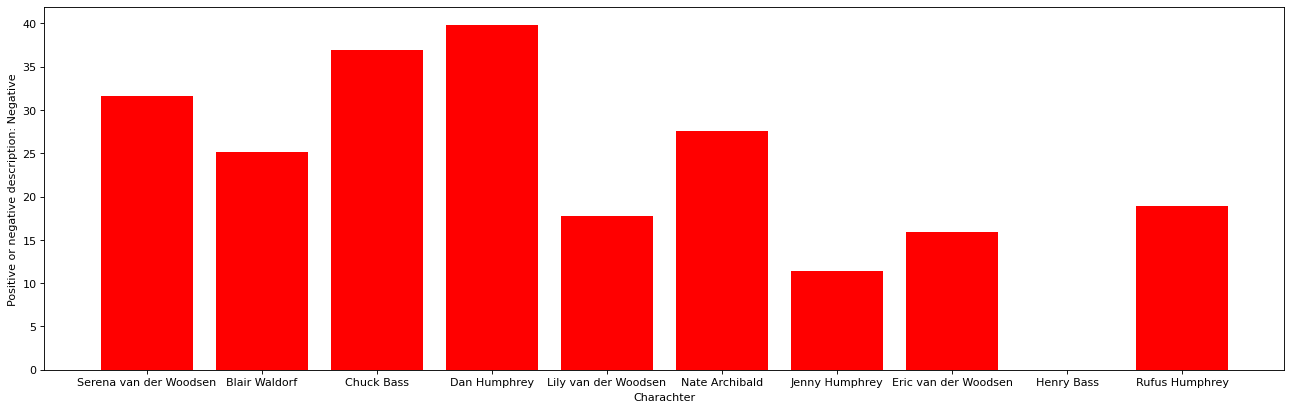

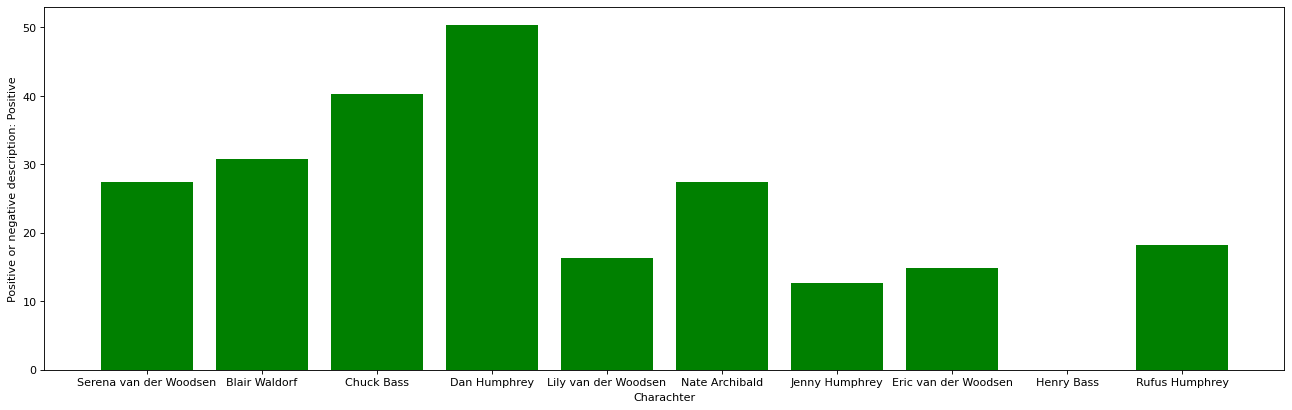

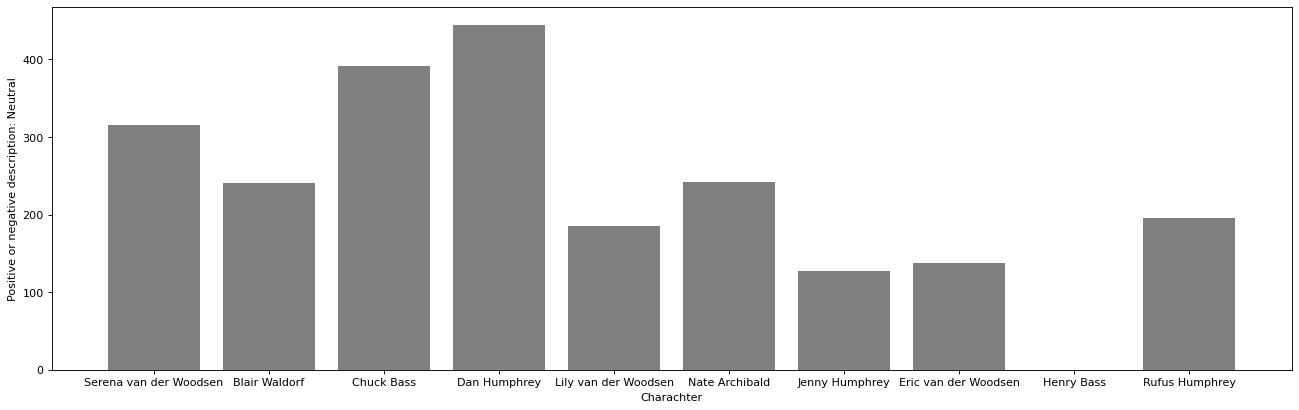

In [57]:
plt.figure(figsize=(20, 6), dpi=80)
plt.xlabel("Charachter")
plt.ylabel("Positive or negative description: Compound")
 
x = []
xn = []
xneu = []
xp = []
for key,value in NegPosComNeu.items():
    x.append(value[0])
    xn.append(value[1])
    xneu.append(value[2])
    xp.append(value[3])
plt.bar(NegPosComNeu.keys(), x, color = 'pink', label = 'Compund')
plt.figure(figsize=(20, 6), dpi=80)
plt.xlabel("Charachter")
plt.ylabel("Positive or negative description: Negative")
plt.bar(NegPosComNeu.keys(), xn, color = 'red', label = 'Negative')

plt.figure(figsize=(20, 6), dpi=80)
plt.xlabel("Charachter")
plt.ylabel("Positive or negative description: Positive")
plt.bar(NegPosComNeu.keys(), xp, color = 'green', label = 'Positive')

plt.figure(figsize=(20, 6), dpi=80)
plt.xlabel("Charachter")
plt.ylabel("Positive or negative description: Neutral")
plt.bar(NegPosComNeu.keys(), xneu, color = 'grey', label = 'Neutral')


### Discussion of result of text analyses

The wordclouds gave us an insight in who the top 10 most conected charachters influence. The sentiment analyses hopefully gave us an insight in how the charachter influence the other charachter ad the social network. 

If we e.g look at Serena van der Woodsen she has a huge impact on blair, Dan and nate. She scores in total that here influence is more bad then good. Even though Serena is a nice person inn the TV-series. She cheats and often do actions that are not thaught trough and therefor innfluence her relationship often more negative then positive. 


# Discussion

## What went well

We have gained a much better overview of the social network of Gossip Girl. The analyzing  of the charachters realtionship gave us a clear overview and was the most important data we wanted to retrive. We did have quite few nodes. This allowed us to create graphs that are easy to read an retreve imformation from for the user. The networks themselfs became visual representations of the the social network of gossip girl and the social comunities inside the social network. We gained the knowledge we needed to find out how and who is Intertwined.

The resluts from the network analyzes gave us who is the most influencial we could further use text analyzes to find out who they ifluence the most ad how they influences. 

In conclusion we managed tounpack the coplex social life of the charachters in GossipGirl. 

After completing this subject, we leave with a backpack full of team experiences and knowledge. We have gotten the oppertunity to explore web API's and go in depth to examine and analyze data. The fact that we have had to make both a video and a website that would present our analyzes has been a very useful an relevant, and very fun!

## Improvments and further work

#### Notebook
The wiki we choose did not have al the desired data we wanted to analyze. For the sentiment analysis we originally wated to analyze the lines of the charachter to find the sentiment of the lines in episodes before and after a break up to determined if they where happier before or after. The wiki did not always have a good html standard witch affected our work. An example is that all <p> in the charachter page was inthe same container without any identifier even though they where under diffrent sections (sections where only divided by a <H>. Our text analyses this not give as useful information as we whised for.
    
We did not read the assigment description good enough and choose a network with few nodes. In hidesight we whised wehad choosen a larger network to work with to make more intresthing connections. 
    
We where only two in the group, and it affected the time we had to work onthe project.

#### Hugo 
We saw this as an abstract project that could be solved in many different ways. Since we initially had no concrete plan for how to visualize the dataset on our website, we chose to go for the websolution that the professional staff recommended: Hugo site deployed with github pages. None of us were familier with this, one in the team; Elise, took this as a challenge. It was difficult to use the templates, because i experienced that it was hard to both resize elements and add images some places. This made some steps more difficult, and resizing of the images was done manually. In retrospective, we should have chosen react with typescript, instead. This is something that the whole team is familiar with, and there is alot of dcumentation on this as well. 


## Contribution

#### Elise Almestad
Elise has had the main resposability for sentiment analyses, the website and cotributed to data fetching.

#### Oline Zachariassen 
Oline has had the main responsability for datafetching, data cleaning, Network and wordcloud.   